# Problem statement
The Nasdaq 100 is a stock market index comprised of 102 equity securities issued by 101 of the Nasdaq's largest nonfinancial companies. It includes sectors such as manufacturing, technology, retail, telecommunication, biotechnology, health care, transportation, media, and service
providers.

The cluster trading strategy is used to build a diverse portfolio of investments. This method enables the identification of different company segments. One advantage of this analysis is that it can help to protect an investor's portfolio from risks.

# Objective
You must now create such segments so that customers can identify segments to invest in and segments to avoid. Use cluster analysis techniques to accomplish this task. You will also need to perform time series forecasting for stock prices.

In [332]:
!pip install -r requirements.txt

In [198]:
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [333]:
plt.style.use('cyberpunk')

In [200]:
# Configs
DATA_PATH='./dataset/'
IMG_PATH='./plots/'
PKL_PATH='./pkl/'
CSV_PATH='./csvs/'
TABLEAU_PATH='./tableau/'
RESOLUTION=200

for path in [DATA_PATH,IMG_PATH,PKL_PATH,CSV_PATH,TABLEAU_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)
        
def save_plots(fig_name):
    plt.savefig(IMG_PATH+fig_name,dpi=RESOLUTION)
    
# Personal configs
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}

# Applied Data Science with Python

## Read Nasdaq 100 market cap.xlsx and nasdaq100_metrics_ratios.xlsx

In [201]:
market_cap=pd.read_excel('dataset/Nasdaq 100 Market cap.xlsx')
metrics_ratio=pd.read_excel('dataset/nasdaq100_metrics_ratios.xlsx')

In [202]:
market_cap.shape

(102, 6)

In [203]:
metrics_ratio.shape

(102, 283)

In [204]:
market_cap.head()

Symbol                             Name     Market Cap Last Sale Net Change  \
0   AAPL                       Apple Inc.  2625740143000   $151.45      $2.00   
1   ABNB                     Airbnb, Inc.    69569944167   $116.65      $0.26   
2   ADBE                       Adobe Inc.   149144569000   $320.81      $4.59   
3    ADI             Analog Devices, Inc.    75484763090   $146.76      $2.23   
4    ADP  Automatic Data Processing, Inc.    98332762096   $236.78      $0.13   

   Percentage Change  
0             0.0134  
1             0.0022  
2             0.0145  
3             0.0154  
4            -0.0005

In [205]:
metrics_ratio.head()

symbol         company                  sector  \
0   AAPL      Apple Inc.  Information Technology   
1   ABNB          Airbnb  Consumer Discretionary   
2   ADBE      Adobe Inc.  Information Technology   
3    ADI  Analog Devices  Information Technology   
4    ADP             ADP  Information Technology   

                                    subsector  asset_turnover_2017  \
0  Technology Hardware, Storage & Peripherals                 0.66   
1          Internet & Direct Marketing Retail                  NaN   
2                        Application Software                 0.54   
3                              Semiconductors                 0.36   
4       Data Processing & Outsourced Services                  NaN   

   asset_turnover_2018  asset_turnover_2019  asset_turnover_2020  \
0                 0.72                 0.74                 0.83   
1                 0.55                 0.64                 0.36   
2                 0.54                 0.57                 0.57   
3                 0.30                 0.29                 0.26   
4                 0.34                 0.34                 0.35   

   asset_turnover_2021  asset_turnover_2022  ...  yoy_eps_growth_2021  \
0                 1.08                  NaN  ...                71.04   
1                 0.50                  NaN  ...                96.46   
2                 0.61                  NaN  ...                -7.48   
3                 0.20                  NaN  ...                 5.49   
4                 0.33                 0.29  ...                 6.49   

   yoy_eps_growth_2022  yoy_eps_growth_latest  yoy_revenue_growth_2017  \
0                  NaN                  -7.69                    11.34   
1                  NaN                 609.09                      NaN   
2                  NaN                  -3.97                    25.51   
3                  NaN                   6.67                    36.64   
4                15.32                  19.05                      NaN   

   yoy_revenue_growth_2018  yoy_revenue_growth_2019  yoy_revenue_growth_2020  \
0                    21.69                     5.36                    11.94   
1                    40.08                    31.58                    31.27   
2                    24.45                    25.21                    16.86   
3                    10.91                    -3.22                    -6.25   
4                     8.65                     7.16                     4.84   

   yoy_revenue_growth_2021  yoy_revenue_growth_2022  yoy_revenue_growth_latest  
0                    38.50                      NaN                       5.11  
1                   -18.11                      NaN                      41.00  
2                    23.69                      NaN                      15.54  
3                    21.07                      NaN                      26.30  
4                     4.95                    11.87                      12.02  

[5 rows x 283 columns]

In [206]:
# Renaming the symbol column of metrics_ratio as Symbol
metrics_ratio.rename(columns={'symbol':'Symbol'},inplace=True)

## Check the stock symbols of the companies in Nasdaq 100 Market cap.xlsx . Only the relevant files in the NASDAQ_DATA folder should be read.

In [207]:
# Extracting the symbol from the market_cap dataset
symbols=market_cap['Symbol'].unique()
symbols

array(['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALGN',
       'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'AVGO',
       'AZN', 'BIDU', 'BIIB', 'BKNG', 'CDNS', 'CEG', 'CHTR', 'CMCSA',
       'COST', 'CPRT', 'CRWD', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'DDOG',
       'DLTR', 'DOCU', 'DXCM', 'EA', 'EBAY', 'EXC', 'FAST', 'FISV',
       'FTNT', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC',
       'INTU', 'ISRG', 'JD', 'KDP', 'KHC', 'KLAC', 'LCID', 'LRCX', 'LULU',
       'MAR', 'MCHP', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL',
       'MSFT', 'MTCH', 'MU', 'NFLX', 'NTES', 'NVDA', 'NXPI', 'ODFL',
       'OKTA', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL',
       'QCOM', 'REGN', 'ROST', 'SBUX', 'SGEN', 'SIRI', 'SNPS', 'SPLK',
       'SWKS', 'TEAM', 'TMUS', 'TSLA', 'TXN', 'VRSK', 'VRSN', 'VRTX',
       'WBA', 'WDAY', 'XEL', 'ZM', 'ZS'], dtype=object)

## Append all files (imported in the previous step) that contain no more than 10 years of data. For this, you may use your discretion.

In [208]:
symbols_data=[]
all_stock_data={}
for symbol in symbols:
    stock_df=pd.read_csv(f'dataset/NASDAQ_DATA/{symbol}.csv',parse_dates=['Date'])
    all_stock_data[symbol]=stock_df
    data_span = (stock_df['Date'].max() - stock_df['Date'].min()).days
    # Check if data span is less than 10 years (3650 days)
    if data_span < 3650:
        # Append the data to the final dataframe
        symbols_data.append(stock_df)

In [209]:
stock_data=pd.concat(symbols_data,ignore_index=True)

In [210]:
stock_data.head()

Date        High         Low        Open       Close      Volume  \
0 2020-12-10  165.000000  141.250000  146.000000  144.710007  70447500.0   
1 2020-12-11  151.500000  135.100006  146.550003  139.250000  26980800.0   
2 2020-12-14  135.300003  125.160004  135.000000  130.000000  16966100.0   
3 2020-12-15  127.599998  121.500000  126.690002  124.800003  10914400.0   
4 2020-12-16  142.000000  124.910004  125.830002  137.990005  20409600.0   

    Adj Close  
0  144.710007  
1  139.250000  
2  130.000000  
3  124.800003  
4  137.990005

In [211]:
stock_data.shape

(17043, 7)

## Collate the two files imported in the previous step to include the fields Market cap and Last sale in addition to the various metrics and ratios already present in nasdaq100_metrics_ratios.xlsx

In [212]:
master_df=pd.merge(metrics_ratio,market_cap[['Symbol','Market Cap','Last Sale']],how='inner',on='Symbol')

In [213]:
master_df.head()

Symbol         company                  sector  \
0   AAPL      Apple Inc.  Information Technology   
1   ABNB          Airbnb  Consumer Discretionary   
2   ADBE      Adobe Inc.  Information Technology   
3    ADI  Analog Devices  Information Technology   
4    ADP             ADP  Information Technology   

                                    subsector  asset_turnover_2017  \
0  Technology Hardware, Storage & Peripherals                 0.66   
1          Internet & Direct Marketing Retail                  NaN   
2                        Application Software                 0.54   
3                              Semiconductors                 0.36   
4       Data Processing & Outsourced Services                  NaN   

   asset_turnover_2018  asset_turnover_2019  asset_turnover_2020  \
0                 0.72                 0.74                 0.83   
1                 0.55                 0.64                 0.36   
2                 0.54                 0.57                 0.57   
3                 0.30                 0.29                 0.26   
4                 0.34                 0.34                 0.35   

   asset_turnover_2021  asset_turnover_2022  ...  yoy_eps_growth_latest  \
0                 1.08                  NaN  ...                  -7.69   
1                 0.50                  NaN  ...                 609.09   
2                 0.61                  NaN  ...                  -3.97   
3                 0.20                  NaN  ...                   6.67   
4                 0.33                 0.29  ...                  19.05   

   yoy_revenue_growth_2017  yoy_revenue_growth_2018  yoy_revenue_growth_2019  \
0                    11.34                    21.69                     5.36   
1                      NaN                    40.08                    31.58   
2                    25.51                    24.45                    25.21   
3                    36.64                    10.91                    -3.22   
4                      NaN                     8.65                     7.16   

   yoy_revenue_growth_2020  yoy_revenue_growth_2021  yoy_revenue_growth_2022  \
0                    11.94                    38.50                      NaN   
1                    31.27                   -18.11                      NaN   
2                    16.86                    23.69                      NaN   
3                    -6.25                    21.07                      NaN   
4                     4.84                     4.95                    11.87   

   yoy_revenue_growth_latest     Market Cap  Last Sale  
0                       5.11  2625740143000    $151.45  
1                      41.00    69569944167    $116.65  
2                      15.54   149144569000    $320.81  
3                      26.30    75484763090    $146.76  
4                      12.02    98332762096    $236.78  

[5 rows x 285 columns]

## Identify the variables whose variance is less than .005 (as these do not contribute to model building), and eliminate those variables

In [214]:
variances=master_df.var(numeric_only=True)

In [215]:
low_var=variances[variances<0.005].index.to_list()

In [216]:
master_df.drop(low_var,axis=1,inplace=True)

In [217]:
master_df.head()

Symbol         company                  sector  \
0   AAPL      Apple Inc.  Information Technology   
1   ABNB          Airbnb  Consumer Discretionary   
2   ADBE      Adobe Inc.  Information Technology   
3    ADI  Analog Devices  Information Technology   
4    ADP             ADP  Information Technology   

                                    subsector  asset_turnover_2017  \
0  Technology Hardware, Storage & Peripherals                 0.66   
1          Internet & Direct Marketing Retail                  NaN   
2                        Application Software                 0.54   
3                              Semiconductors                 0.36   
4       Data Processing & Outsourced Services                  NaN   

   asset_turnover_2018  asset_turnover_2019  asset_turnover_2020  \
0                 0.72                 0.74                 0.83   
1                 0.55                 0.64                 0.36   
2                 0.54                 0.57                 0.57   
3                 0.30                 0.29                 0.26   
4                 0.34                 0.34                 0.35   

   asset_turnover_2021  asset_turnover_2022  ...  yoy_eps_growth_latest  \
0                 1.08                  NaN  ...                  -7.69   
1                 0.50                  NaN  ...                 609.09   
2                 0.61                  NaN  ...                  -3.97   
3                 0.20                  NaN  ...                   6.67   
4                 0.33                 0.29  ...                  19.05   

   yoy_revenue_growth_2017  yoy_revenue_growth_2018  yoy_revenue_growth_2019  \
0                    11.34                    21.69                     5.36   
1                      NaN                    40.08                    31.58   
2                    25.51                    24.45                    25.21   
3                    36.64                    10.91                    -3.22   
4                      NaN                     8.65                     7.16   

   yoy_revenue_growth_2020  yoy_revenue_growth_2021  yoy_revenue_growth_2022  \
0                    11.94                    38.50                      NaN   
1                    31.27                   -18.11                      NaN   
2                    16.86                    23.69                      NaN   
3                    -6.25                    21.07                      NaN   
4                     4.84                     4.95                    11.87   

   yoy_revenue_growth_latest     Market Cap  Last Sale  
0                       5.11  2625740143000    $151.45  
1                      41.00    69569944167    $116.65  
2                      15.54   149144569000    $320.81  
3                      26.30    75484763090    $146.76  
4                      12.02    98332762096    $236.78  

[5 rows x 281 columns]

## Delete the variables in nasdaq100_metrics_ratios.xlsx where 30% or more of the values are missing

In [218]:
threshold=0.3
metrics_ratio.dropna(thresh=len(metrics_ratio)*(1-threshold),axis=1)
metrics_ratio.head()

Symbol         company                  sector  \
0   AAPL      Apple Inc.  Information Technology   
1   ABNB          Airbnb  Consumer Discretionary   
2   ADBE      Adobe Inc.  Information Technology   
3    ADI  Analog Devices  Information Technology   
4    ADP             ADP  Information Technology   

                                    subsector  asset_turnover_2017  \
0  Technology Hardware, Storage & Peripherals                 0.66   
1          Internet & Direct Marketing Retail                  NaN   
2                        Application Software                 0.54   
3                              Semiconductors                 0.36   
4       Data Processing & Outsourced Services                  NaN   

   asset_turnover_2018  asset_turnover_2019  asset_turnover_2020  \
0                 0.72                 0.74                 0.83   
1                 0.55                 0.64                 0.36   
2                 0.54                 0.57                 0.57   
3                 0.30                 0.29                 0.26   
4                 0.34                 0.34                 0.35   

   asset_turnover_2021  asset_turnover_2022  ...  yoy_eps_growth_2021  \
0                 1.08                  NaN  ...                71.04   
1                 0.50                  NaN  ...                96.46   
2                 0.61                  NaN  ...                -7.48   
3                 0.20                  NaN  ...                 5.49   
4                 0.33                 0.29  ...                 6.49   

   yoy_eps_growth_2022  yoy_eps_growth_latest  yoy_revenue_growth_2017  \
0                  NaN                  -7.69                    11.34   
1                  NaN                 609.09                      NaN   
2                  NaN                  -3.97                    25.51   
3                  NaN                   6.67                    36.64   
4                15.32                  19.05                      NaN   

   yoy_revenue_growth_2018  yoy_revenue_growth_2019  yoy_revenue_growth_2020  \
0                    21.69                     5.36                    11.94   
1                    40.08                    31.58                    31.27   
2                    24.45                    25.21                    16.86   
3                    10.91                    -3.22                    -6.25   
4                     8.65                     7.16                     4.84   

   yoy_revenue_growth_2021  yoy_revenue_growth_2022  yoy_revenue_growth_latest  
0                    38.50                      NaN                       5.11  
1                   -18.11                      NaN                      41.00  
2                    23.69                      NaN                      15.54  
3                    21.07                      NaN                      26.30  
4                     4.95                    11.87                      12.02  

[5 rows x 283 columns]

## Perform missing value imputation for variables with less than 30% missing values by considering the company's sector

In [219]:
# Check the missing value for all the features
master_df.isna().mean().sort_values(ascending=False)

goodwill_to_asset_latest            1.000000
days_inventory_2022                 0.882353
inventory_turnover_2022             0.882353
price_earnings_growth_ratio_2022    0.872549
rate_of_return_2022                 0.852941
                                      ...   
enterprise_value_to_ebit_latest     0.000000
equity_to_assets_latest             0.000000
equity_to_assets_2021               0.000000
equity_to_assets_2020               0.000000
Last Sale                           0.000000
Length: 281, dtype: float64

In [220]:
null_cols=master_df.isna().mean().sort_values(ascending=False)
null_cols=null_cols[null_cols>0]

In [221]:
len(null_cols[null_cols<0.3])

149

In [222]:
missing_threshold=0.3
# Selecting the column that have null values less that 30%
low_missing_cols = master_df.columns[(master_df.isnull().mean() < missing_threshold) & (master_df.isnull().mean()>0)]
# Filter out non-numeric columns or adjust criteria as needed
low_missing_cols = [col for col in low_missing_cols if pd.api.types.is_numeric_dtype(master_df[col])]
for sector in master_df['sector'].unique():
    sector_df = master_df.loc[master_df['sector'] == sector]
    for col in low_missing_cols:
        # Check a group of data having a particular sector contain any null value or not
        if sector_df[col].isnull().any():
            median_value = sector_df[col].median()
            master_df.loc[master_df['sector'] == sector, col] = master_df.loc[master_df['sector'] == sector, col].fillna(median_value)

In [223]:
master_df.loc[master_df['sector']=='Utilities']['price_to_free_cashflow_latest']

6    NaN
21   NaN
37   NaN
99   NaN
Name: price_to_free_cashflow_latest, dtype: float64

- After imputing the features that have missing values less than 30%, there the some null vlaues
- The reason is the particular features in a particular sector contain all null values like the Utilities Sector for price_to_free_cashflow_latest

In [224]:
# Lets fill this features have missing value less than 30% by the median value
rem_30pct_col=null_cols[null_cols<0.3].index.to_list()

In [225]:
for col in rem_30pct_col:
    master_df[col]=master_df[col].fillna(master_df[col].median())

In [226]:
master_df.head()

Symbol         company                  sector  \
0   AAPL      Apple Inc.  Information Technology   
1   ABNB          Airbnb  Consumer Discretionary   
2   ADBE      Adobe Inc.  Information Technology   
3    ADI  Analog Devices  Information Technology   
4    ADP             ADP  Information Technology   

                                    subsector  asset_turnover_2017  \
0  Technology Hardware, Storage & Peripherals                0.660   
1          Internet & Direct Marketing Retail                0.825   
2                        Application Software                0.540   
3                              Semiconductors                0.360   
4       Data Processing & Outsourced Services                0.555   

   asset_turnover_2018  asset_turnover_2019  asset_turnover_2020  \
0                 0.72                 0.74                 0.83   
1                 0.55                 0.64                 0.36   
2                 0.54                 0.57                 0.57   
3                 0.30                 0.29                 0.26   
4                 0.34                 0.34                 0.35   

   asset_turnover_2021  asset_turnover_2022  ...  yoy_eps_growth_latest  \
0                 1.08                  NaN  ...                  -7.69   
1                 0.50                  NaN  ...                 609.09   
2                 0.61                  NaN  ...                  -3.97   
3                 0.20                  NaN  ...                   6.67   
4                 0.33                 0.29  ...                  19.05   

   yoy_revenue_growth_2017  yoy_revenue_growth_2018  yoy_revenue_growth_2019  \
0                   11.340                    21.69                     5.36   
1                   23.355                    40.08                    31.58   
2                   25.510                    24.45                    25.21   
3                   36.640                    10.91                    -3.22   
4                   12.900                     8.65                     7.16   

   yoy_revenue_growth_2020  yoy_revenue_growth_2021  yoy_revenue_growth_2022  \
0                    11.94                    38.50                      NaN   
1                    31.27                   -18.11                      NaN   
2                    16.86                    23.69                      NaN   
3                    -6.25                    21.07                      NaN   
4                     4.84                     4.95                    11.87   

   yoy_revenue_growth_latest     Market Cap  Last Sale  
0                       5.11  2625740143000    $151.45  
1                      41.00    69569944167    $116.65  
2                      15.54   149144569000    $320.81  
3                      26.30    75484763090    $146.76  
4                      12.02    98332762096    $236.78  

[5 rows x 281 columns]

In [227]:
null_cols=master_df.isna().mean().sort_values(ascending=False)
null_cols=null_cols[null_cols>0]

In [228]:
fig = go.Figure(data=[go.Bar(x=null_cols.index, y=null_cols.values)])

fig.update_layout(title='Null Values Count',xaxis_title='Features',yaxis_title='Values')

# Show the plot
fig.show()

In [229]:
master_df.drop('goodwill_to_asset_latest',axis=1,inplace=True)

In [230]:
null_cols=master_df.isna().mean().sort_values(ascending=False)
remove_index=null_cols[null_cols>=0.7].index
remove_index

Index(['inventory_turnover_2022', 'days_inventory_2022',
       'price_earnings_growth_ratio_2022', 'interest_coverage_2022',
       'rate_of_return_2022', 'buyback_yield_2022',
       'price_to_earnings_ratio_nri_2022', 'price_to_earnings_ratio_2022',
       'e10_2022', 'effective_interest_rate_2022',
       'enterprise_value_to_ebitda_2022', 'enterprise_value_to_ebit_2022',
       'yoy_eps_growth_2022', 'scaled_net_operating_assets_2022',
       'cash_ratio_2022', 'debt_to_equity_2022', 'price_to_book_ratio_2022',
       'enterprise_value_to_revenue_2022', 'current_ratio_2022',
       'cogs_to_revenue_2022', 'equity_to_assets_2022',
       'liabilities_to_assets_2022', 'price_to_free_cashflow_2022',
       'zscore_2022', 'cash_to_debt_2022', 'debt_to_assets_2022',
       'mscore_2022', 'earning_yield_greenblatt_2022', 'fscore_2022',
       'yoy_revenue_growth_2022', 'debt_to_revenue_2022',
       'gross_profit_to_assets_2022', 'asset_turnover_2022',
       'price_to_operating_cashflo

In [231]:
master_df.drop(remove_index,axis=1,inplace=True)

In [232]:
null_cols=master_df.isna().mean().sort_values(ascending=False)
null_cols=null_cols[null_cols>0].index
null_cols

Index(['inventory_turnover_2017', 'days_inventory_2017',
       'price_earnings_growth_ratio_2017', 'interest_coverage_2017',
       'longterm_debt_to_assets_2017', 'effective_interest_rate_2017',
       'price_to_free_cashflow_2017', 'buyback_yield_2017',
       'rate_of_return_2017', 'inventory_to_revenue_2019', 'cash_to_debt_2017',
       'debt_to_equity_2017', 'debt_to_ebitda_2017',
       'price_to_earnings_ratio_2017', 'debt_to_revenue_2017',
       'price_to_earnings_ratio_nri_2017', 'debt_to_assets_2017', 'e10_2017',
       'inventory_turnover_2018', 'inventory_to_revenue_2021',
       'days_inventory_2018', 'inventory_turnover_2019', 'days_inventory_2019',
       'price_earnings_growth_ratio_2021', 'price_to_operating_cashflow_2017',
       'inventory_to_revenue_2020', 'price_to_book_ratio_2017',
       'inventory_turnover_2021', 'days_inventory_2020', 'days_inventory_2021',
       'yoy_eps_growth_2017', 'mscore_2017', 'inventory_turnover_2020',
       'earning_yield_greenblat

In [233]:
imputer=SimpleImputer(strategy='mean')

for col in null_cols:
    master_df[col]=imputer.fit_transform(master_df[[col]])

In [234]:
master_df.isna().sum().any()

False

- The dataset is now cleaned

## Analyze the effect of COVID on stock prices in detail, create visuals to support the insights, and address the following:

### Which sectors and companies saw the greatest impact, and which ones saw the least? You may use growth or degrowth as a measure of impact and may perform week over week,month over month (Mom), quarter over quarter ( QoQ ), or year over year (YoY) analysis as appropriate.

In [235]:
# Select the stocks that have data cotain 2019 as covid start from 2019 there is no reason to select a stock before 2019 to analyse impact of covid
selected_stock=[]
for symb in symbols:
    df=pd.read_csv(f'dataset/NASDAQ_DATA/{symb}.csv',parse_dates=['Date'])
    df['Symbol']=symb
    selected_stock.append(df)

In [236]:
master_stock=pd.concat(selected_stock,ignore_index=True)
master_stock=pd.merge(master_stock,metrics_ratio[['Symbol','sector','subsector']],on='Symbol')
master_stock.head()

Date      High       Low      Open     Close       Volume  Adj Close  \
0 1999-12-31  0.918527  0.888393  0.901228  0.917969  163811200.0   0.782493   
1 2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.851942   
2 2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.780115   
3 2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.791530   
4 2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.723033   

  Symbol                  sector                                   subsector  
0   AAPL  Information Technology  Technology Hardware, Storage & Peripherals  
1   AAPL  Information Technology  Technology Hardware, Storage & Peripherals  
2   AAPL  Information Technology  Technology Hardware, Storage & Peripherals  
3   AAPL  Information Technology  Technology Hardware, Storage & Peripherals  
4   AAPL  Information Technology  Technology Hardware, Storage & Peripherals

In [334]:
def plot_line(symbol):
    df=symbol.copy()
    symb=symbol['Symbol'].iloc[0]
    df['Year']=df['Date'].dt.year
    df=df[df['Year']>=2019]
    df=df.groupby('Year')['Open'].mean()
    df.plot()
    plt.xticks(df.index.astype(int))
    plt.title(symb)
    save_plots(f'Stock trends {symb}')
    mplcyberpunk.add_glow_effects()
    plt.show()

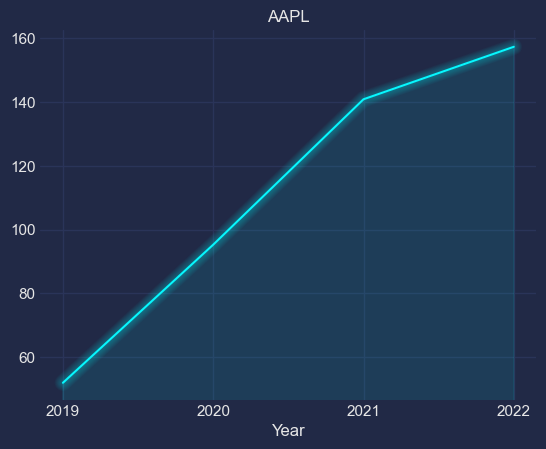

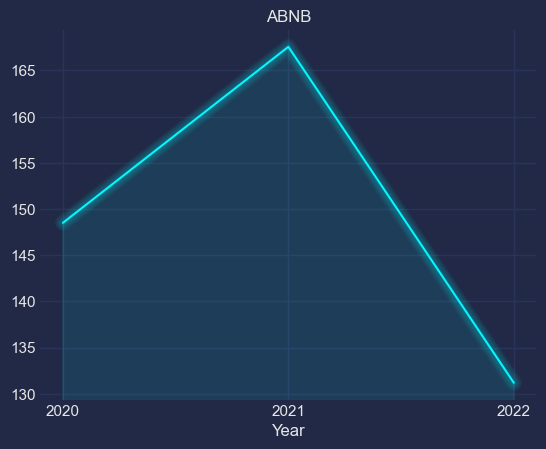

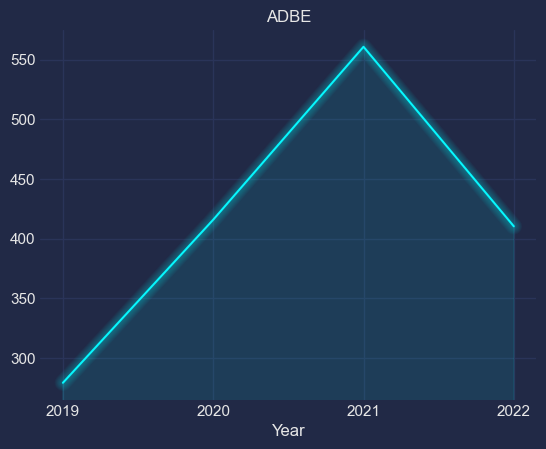

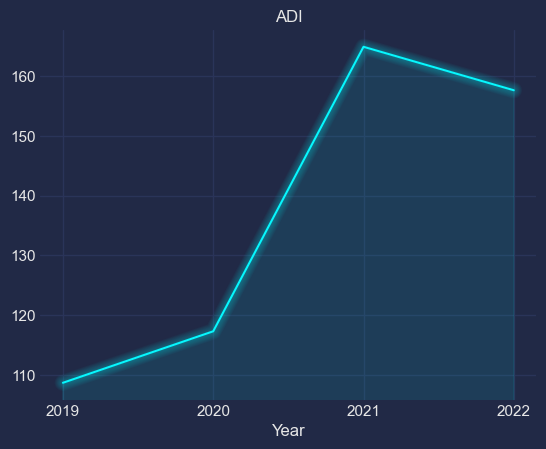

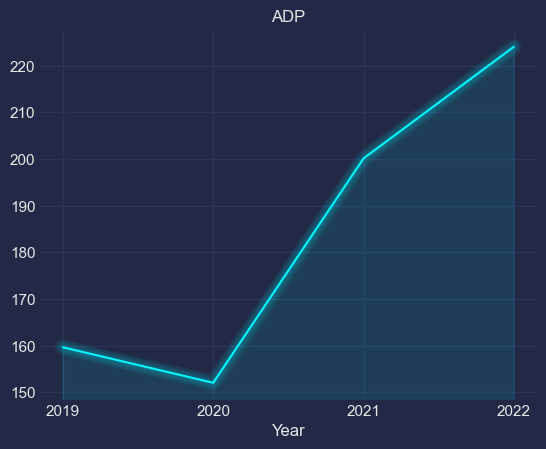

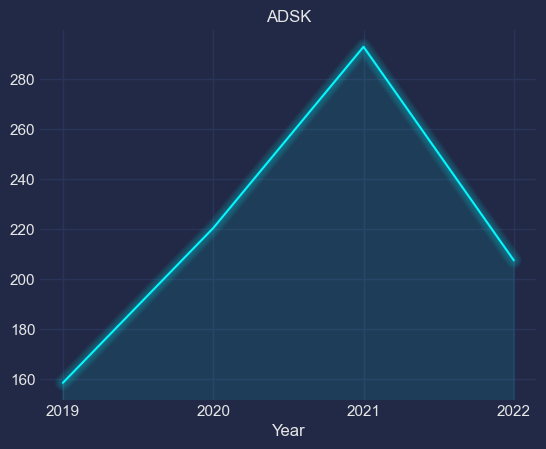

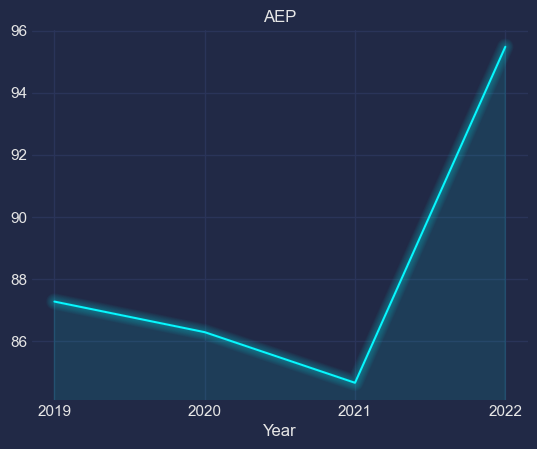

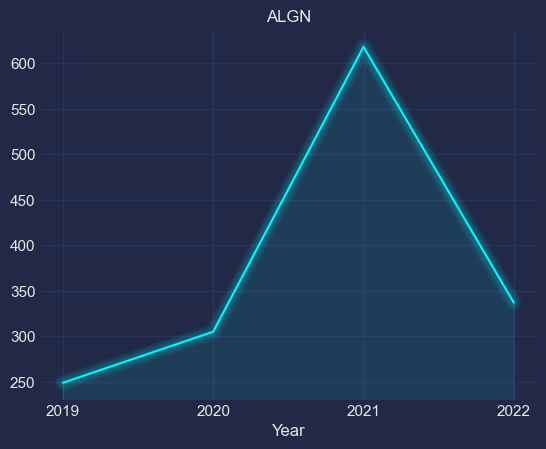

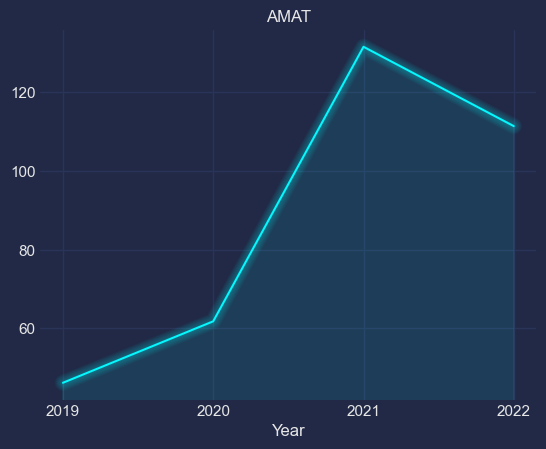

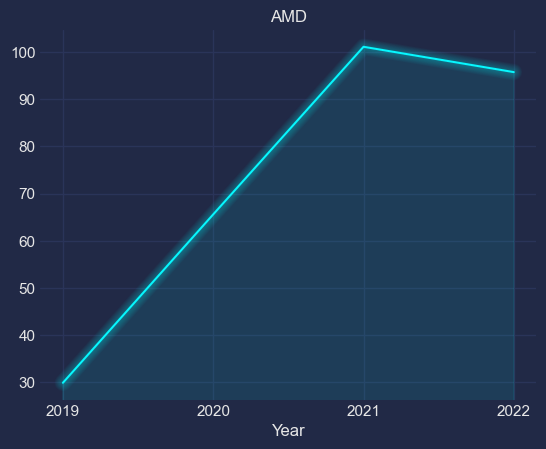

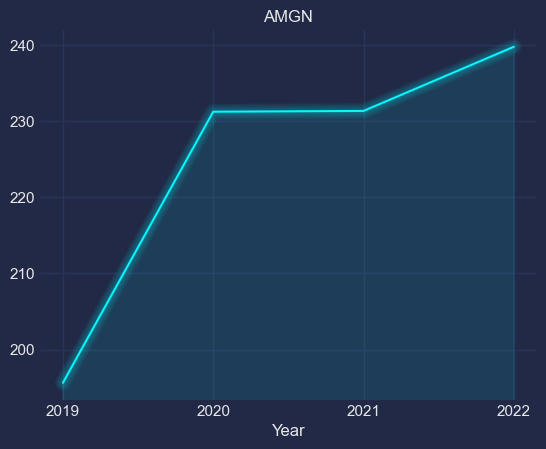

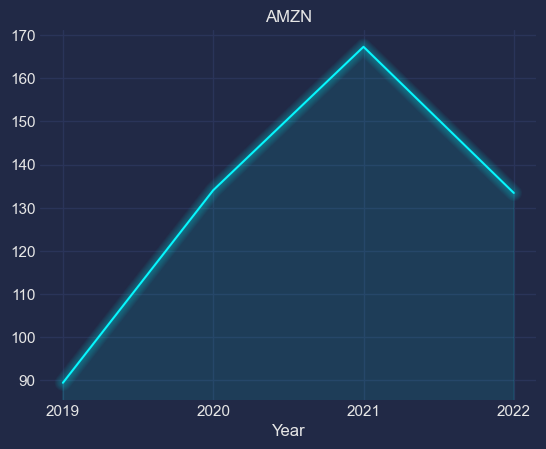

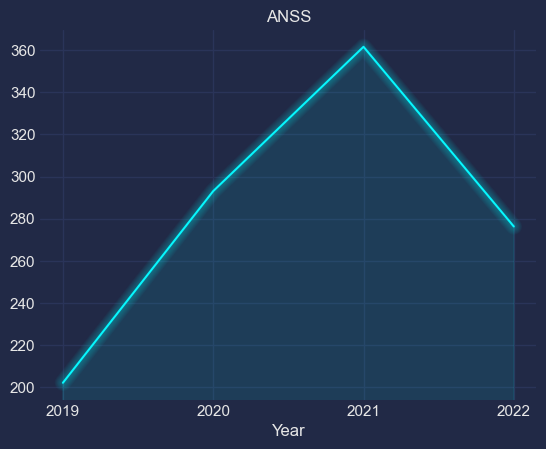

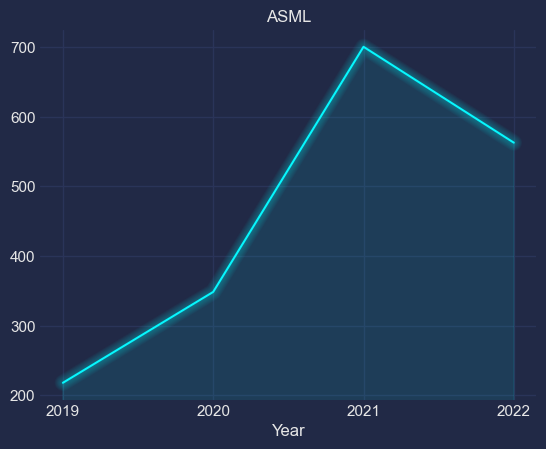

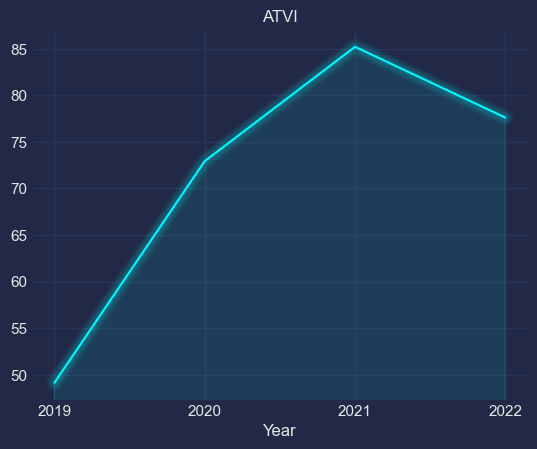

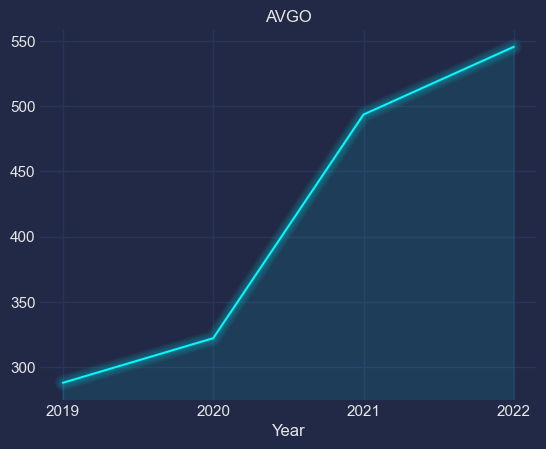

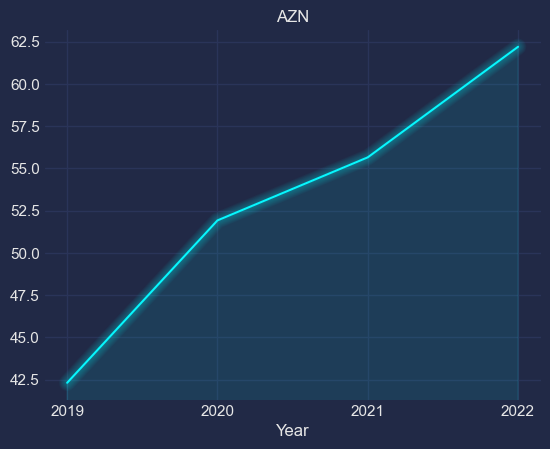

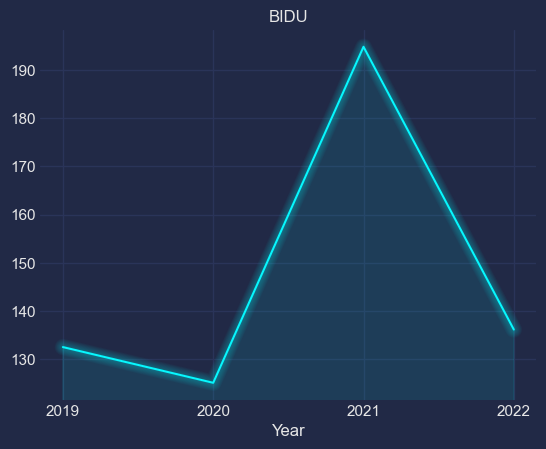

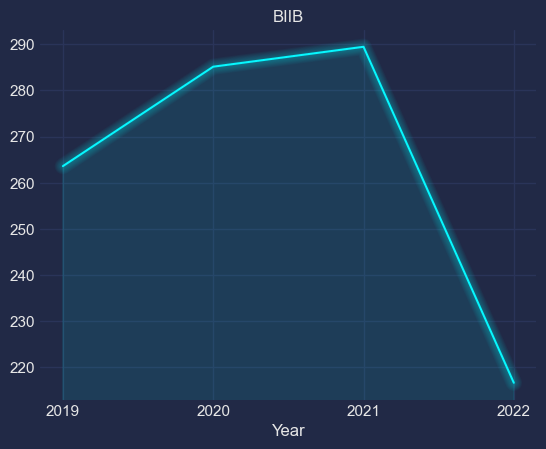

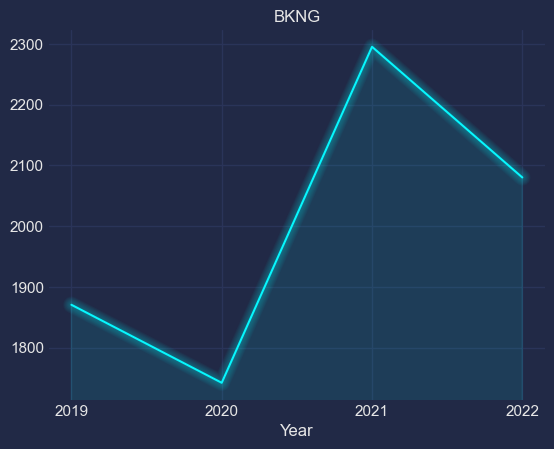

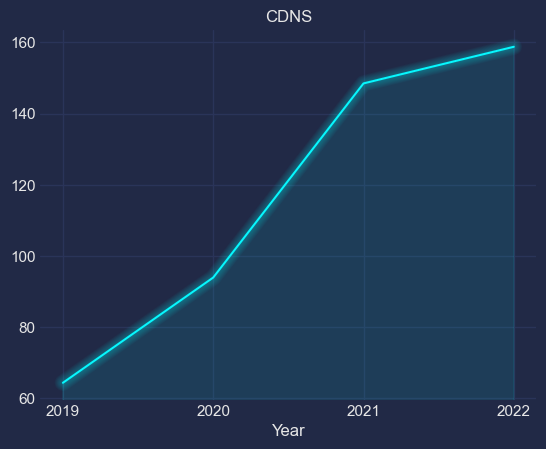

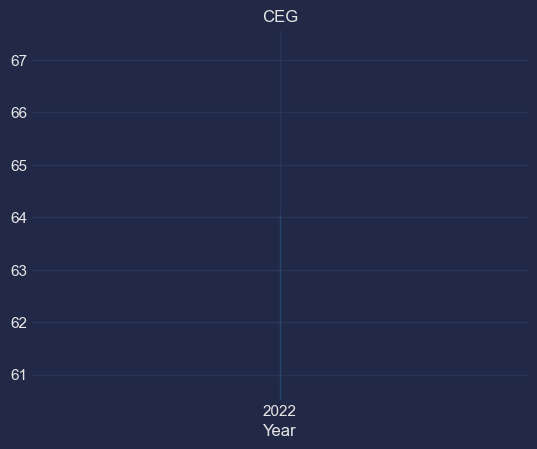

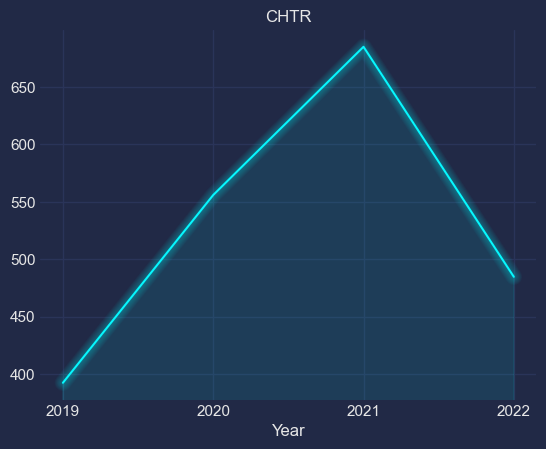

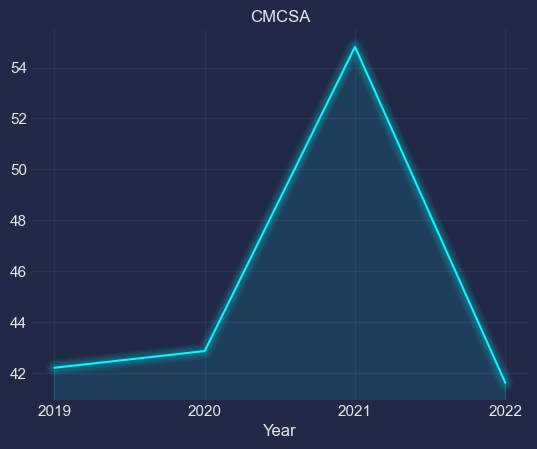

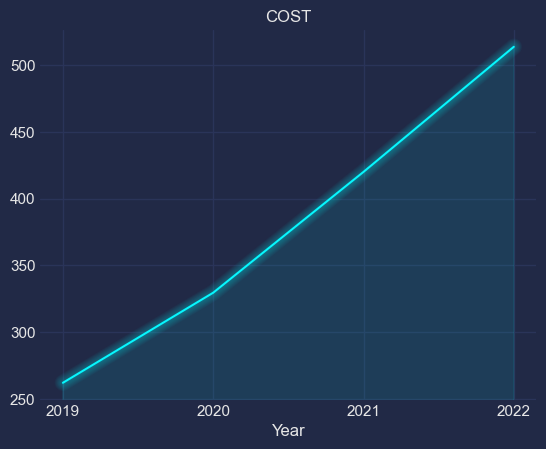

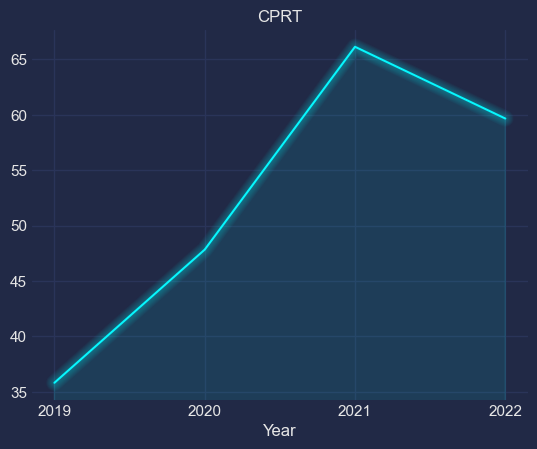

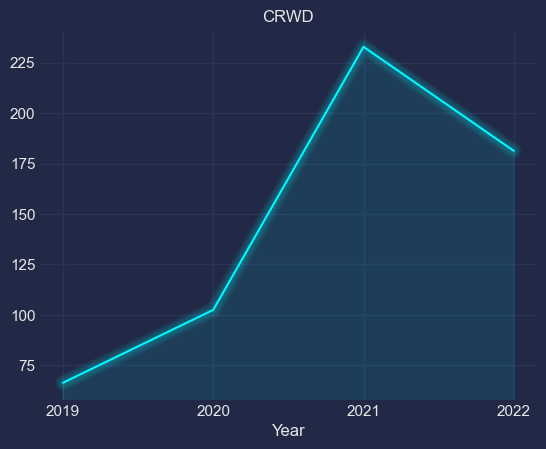

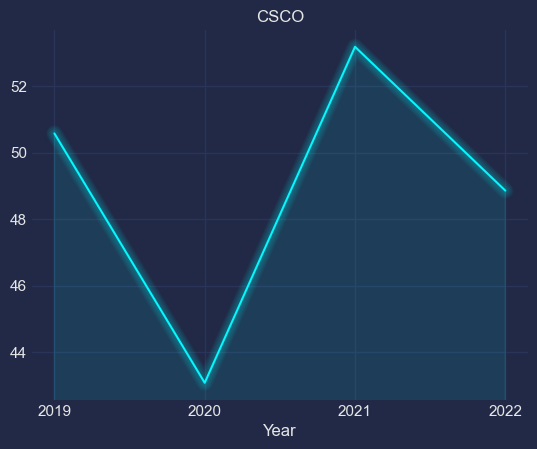

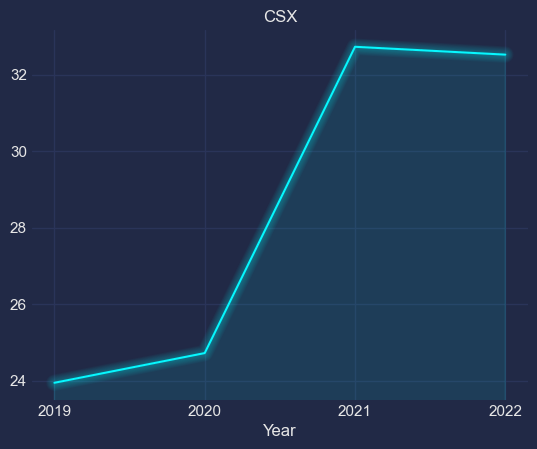

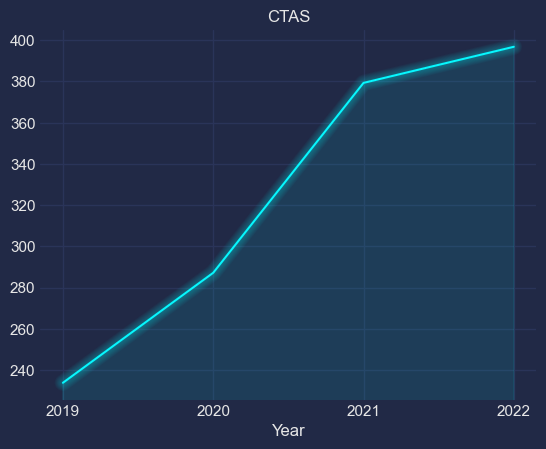

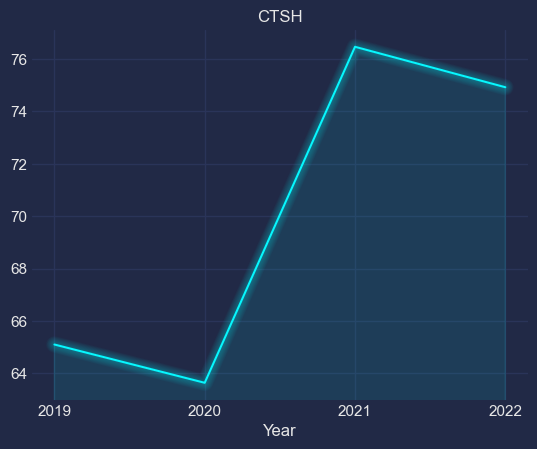

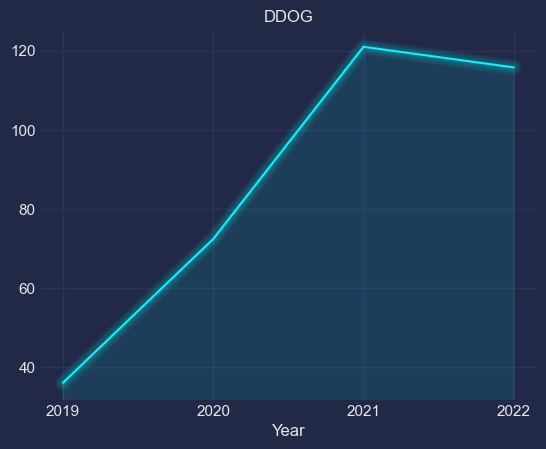

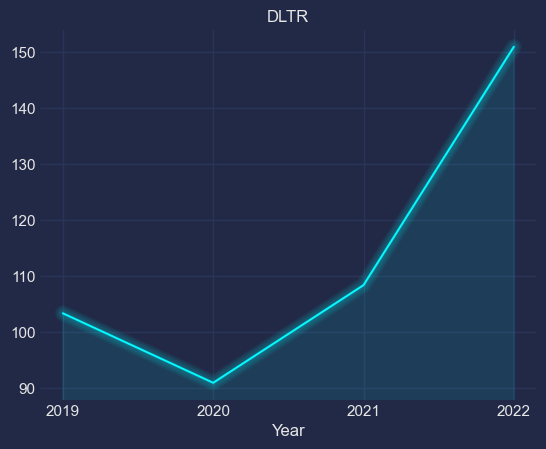

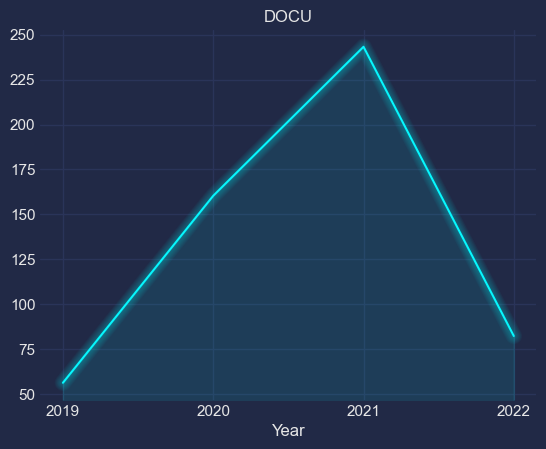

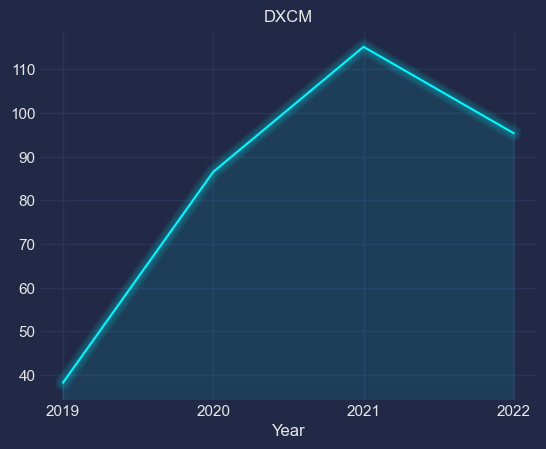

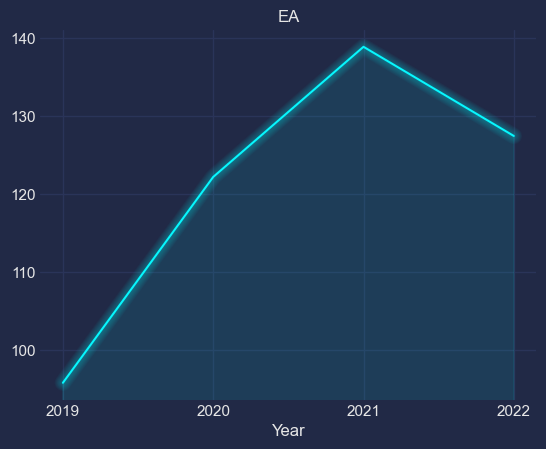

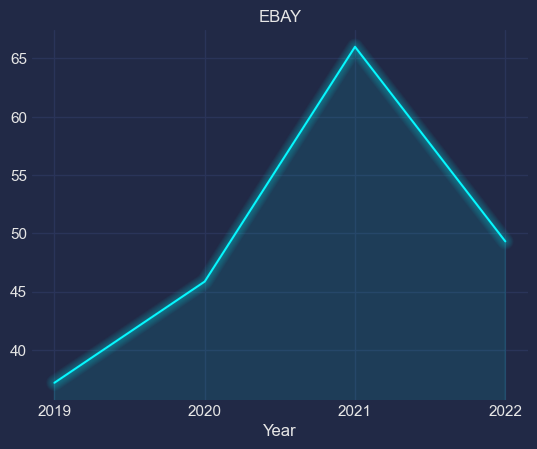

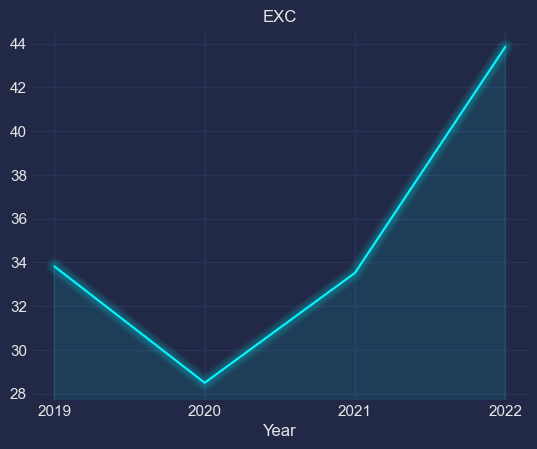

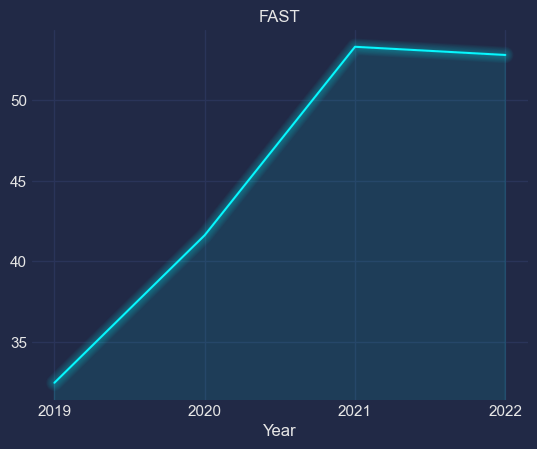

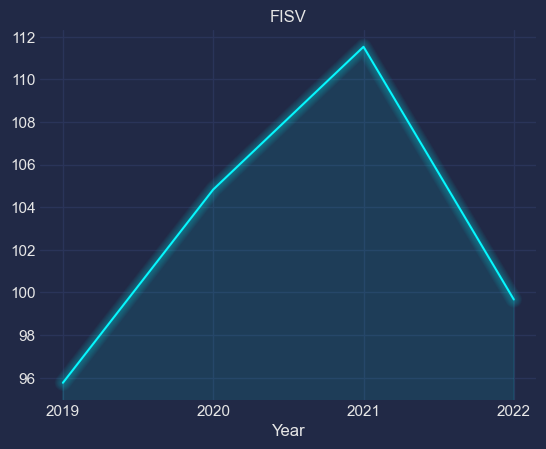

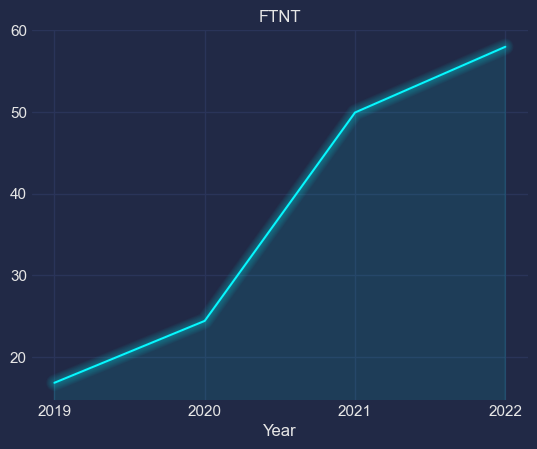

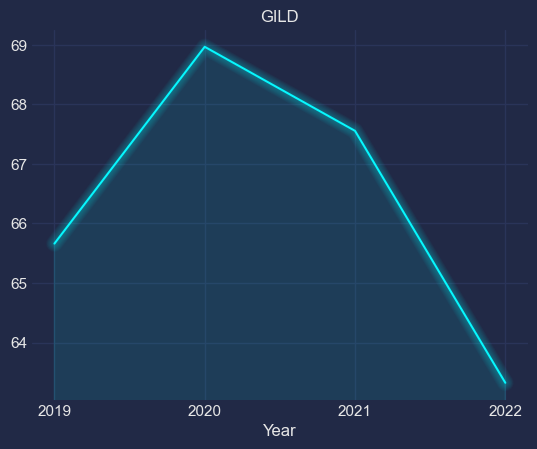

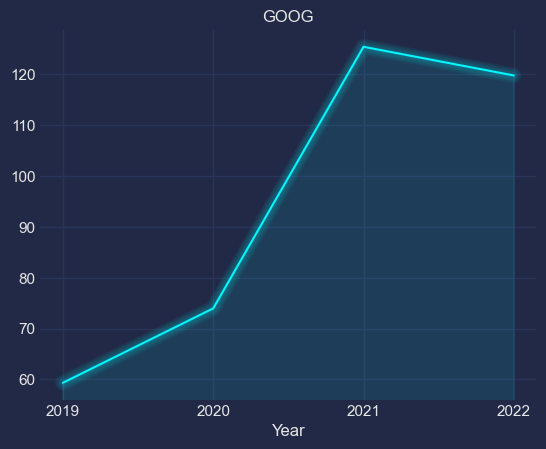

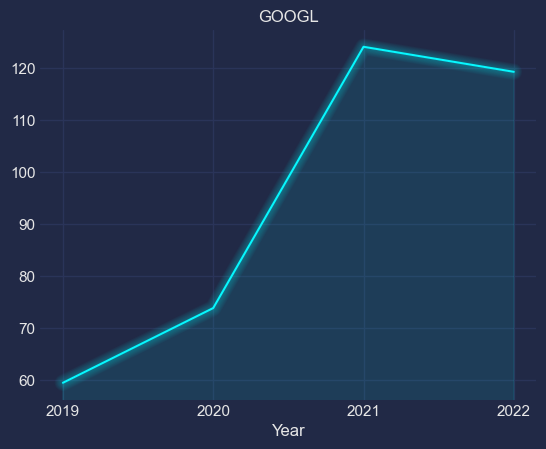

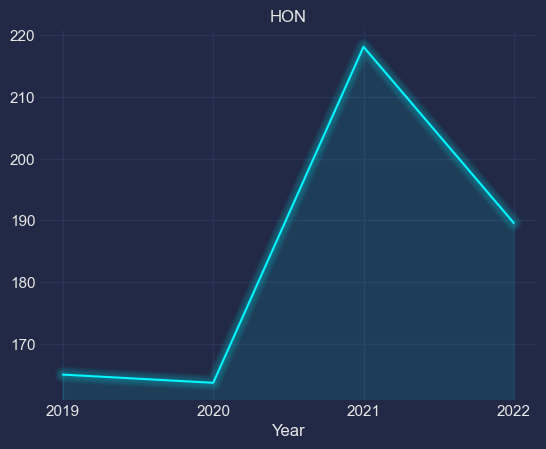

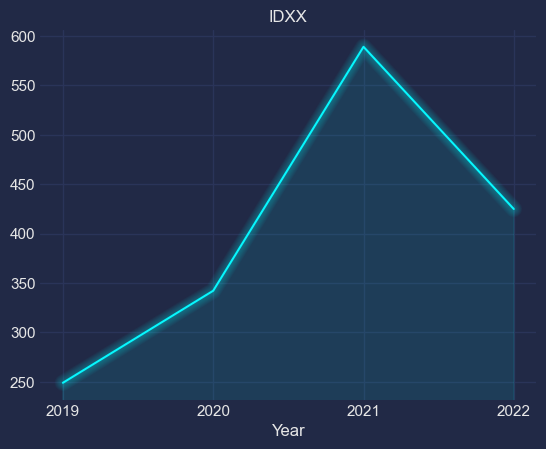

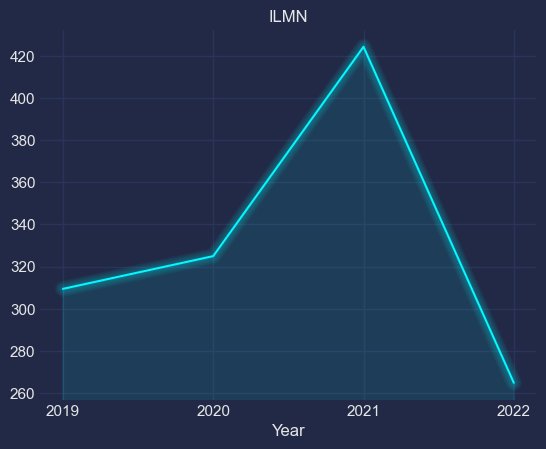

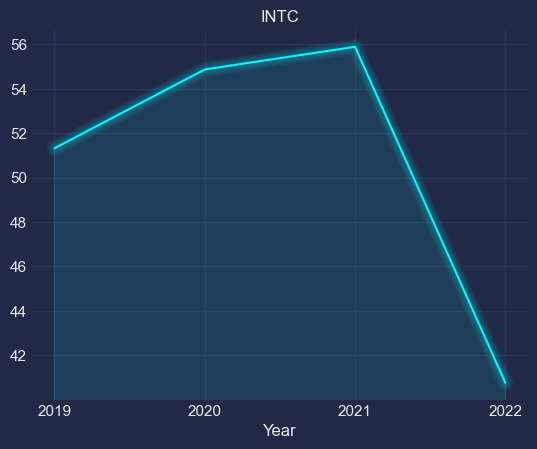

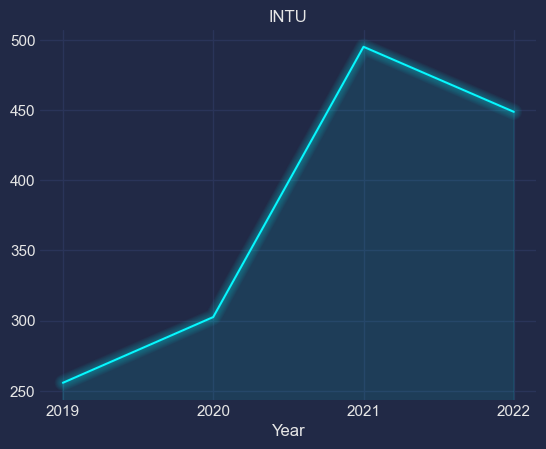

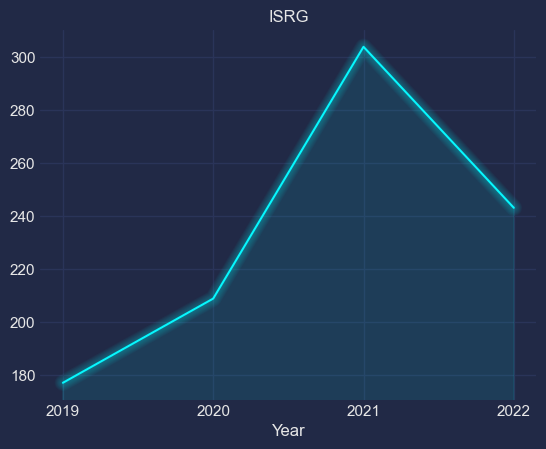

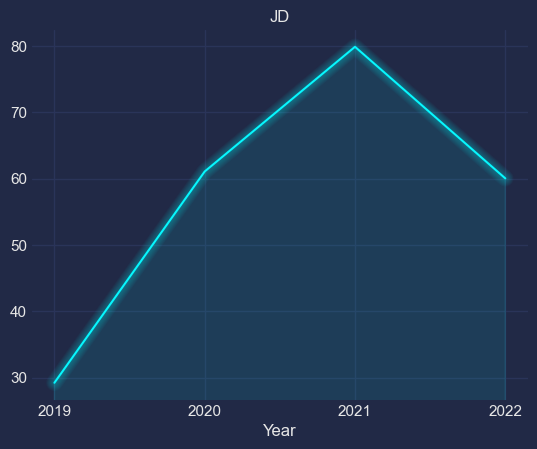

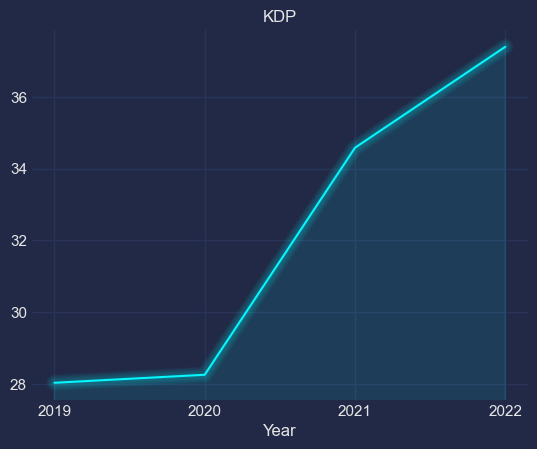

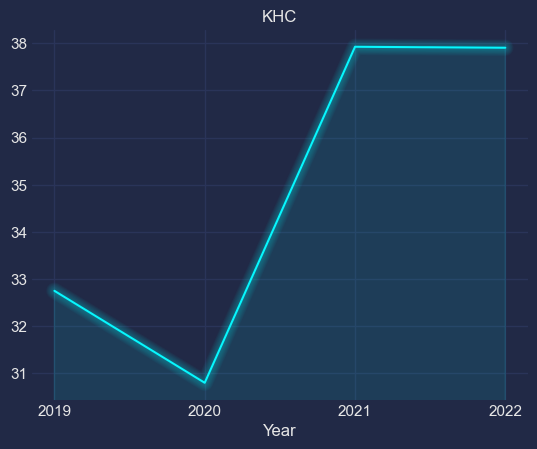

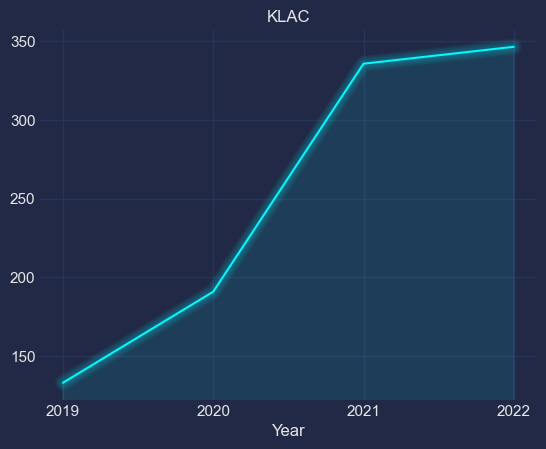

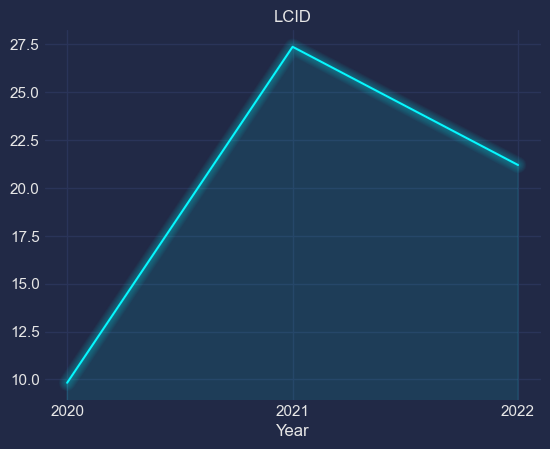

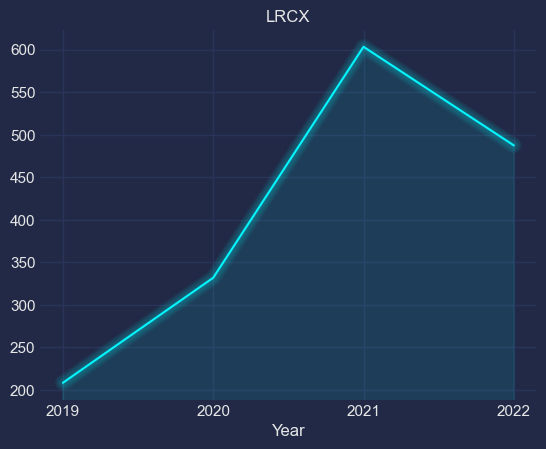

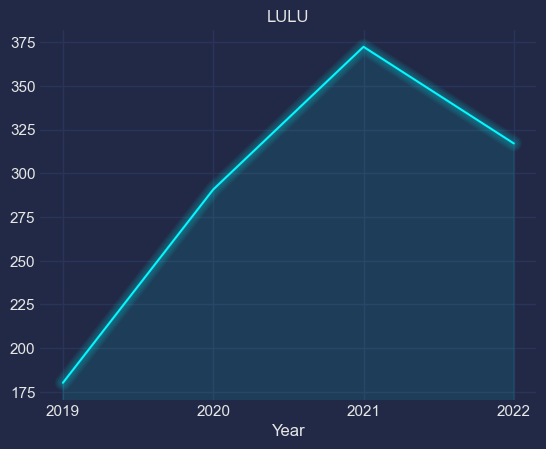

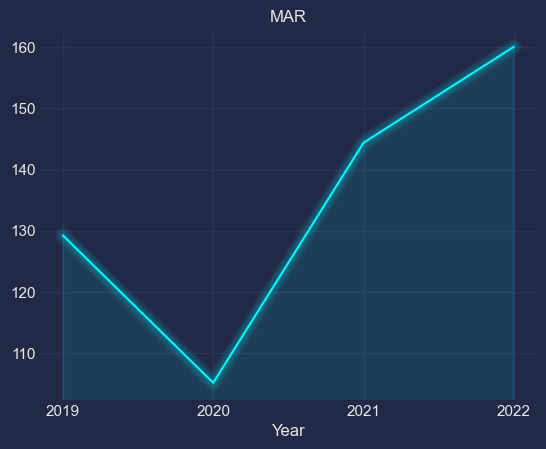

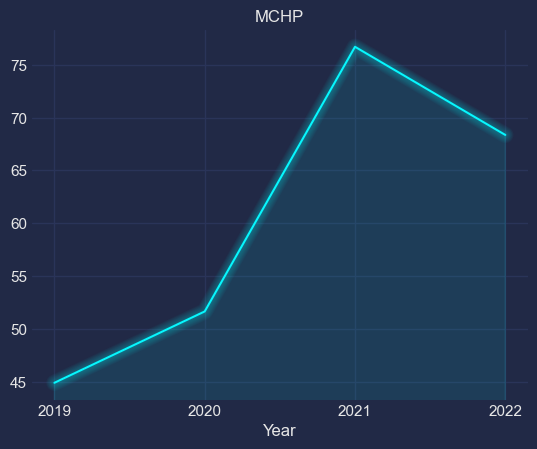

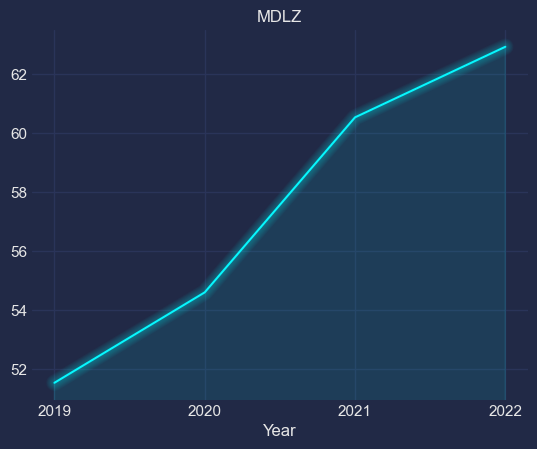

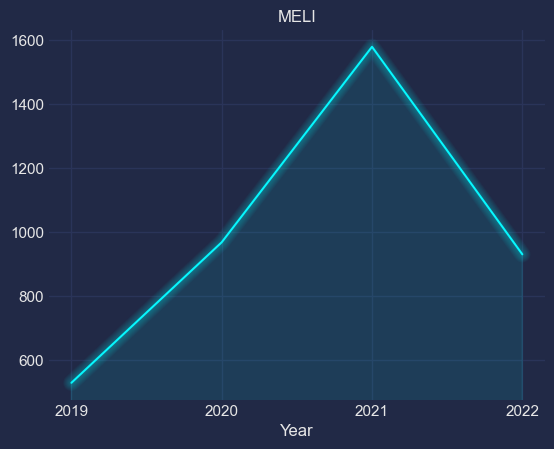

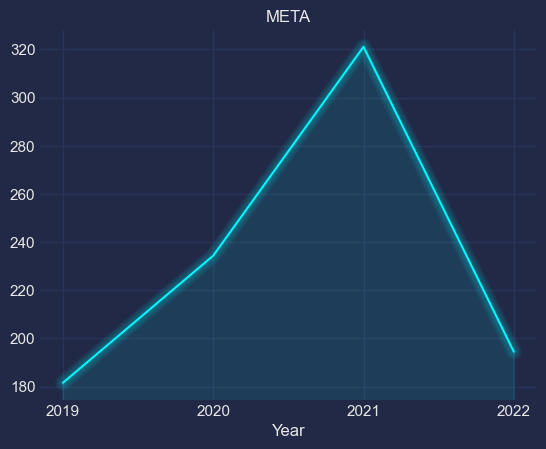

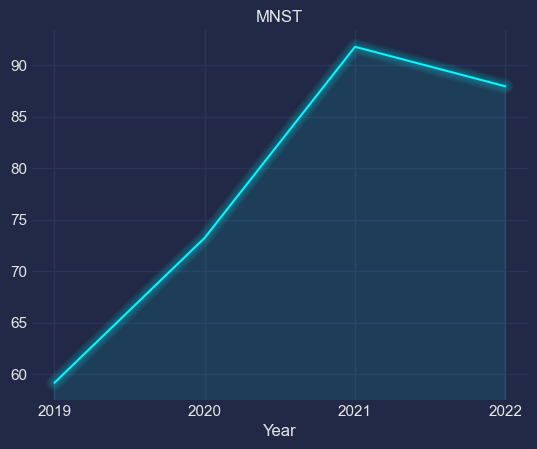

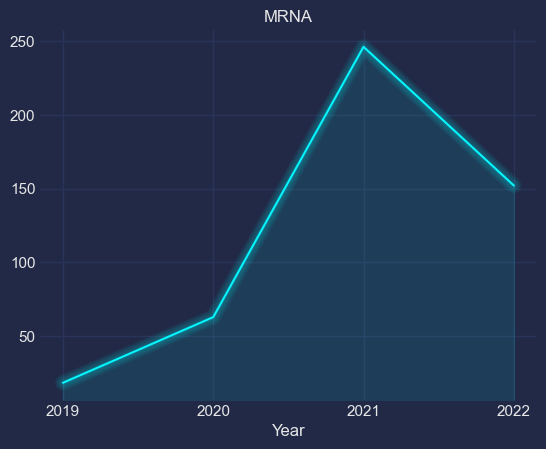

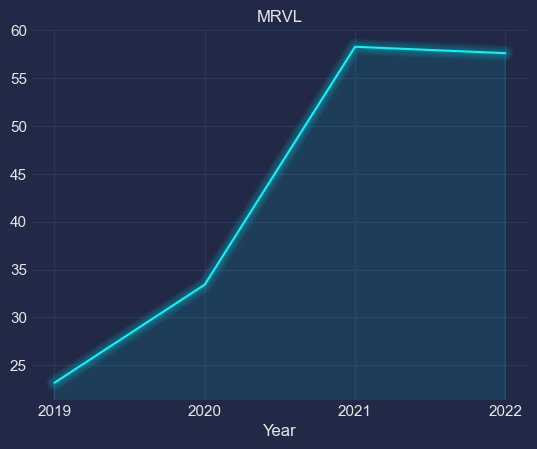

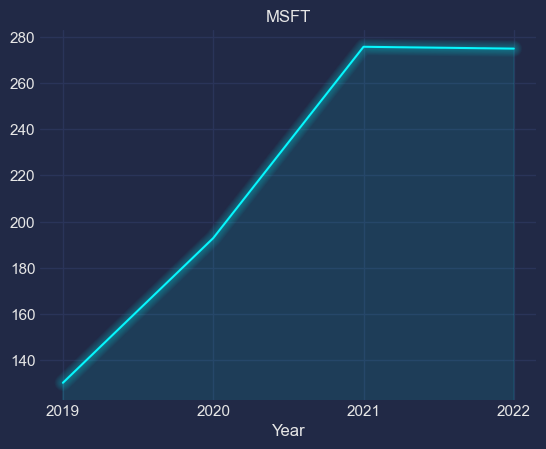

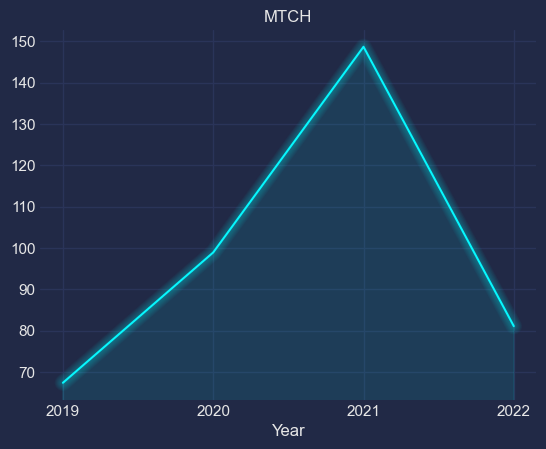

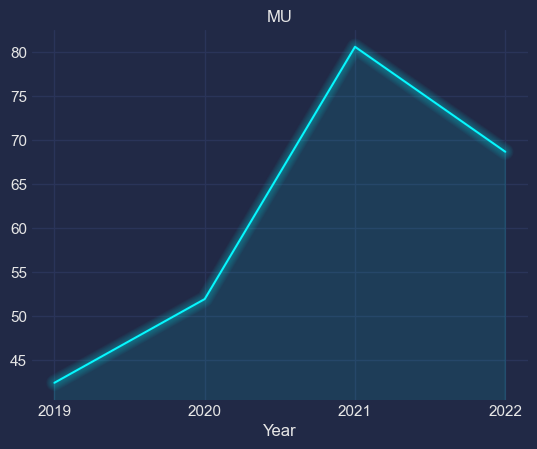

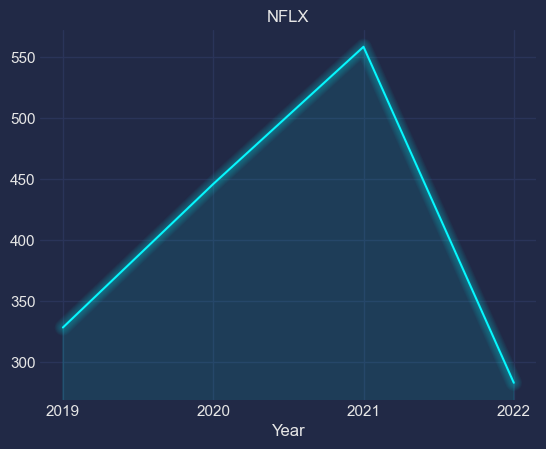

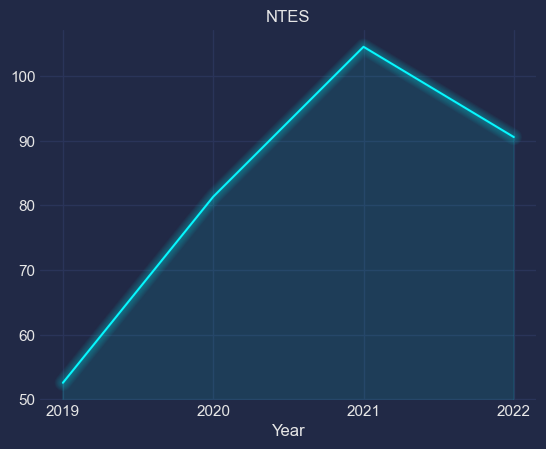

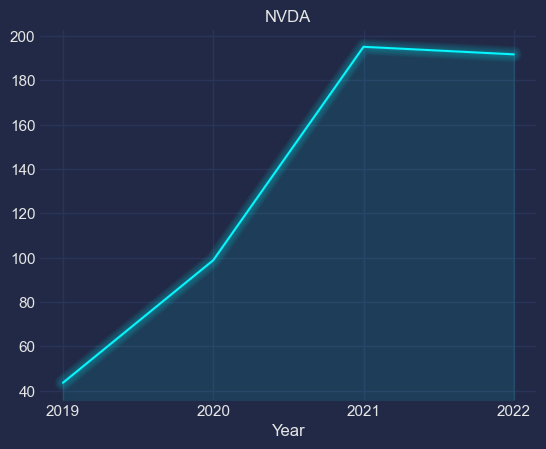

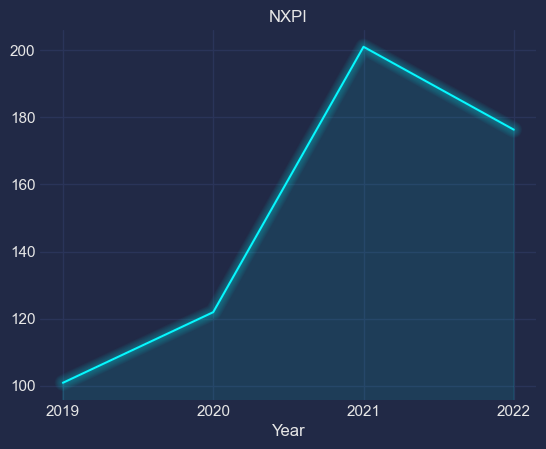

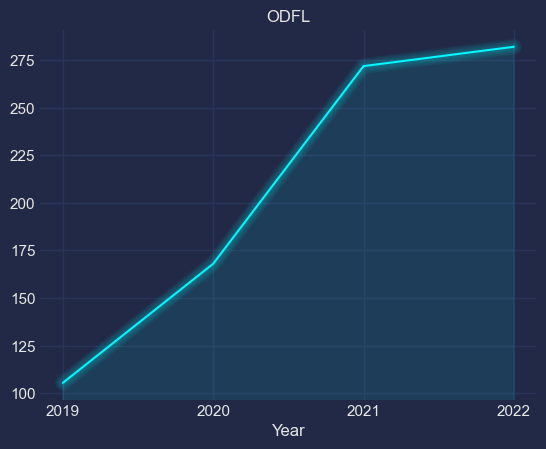

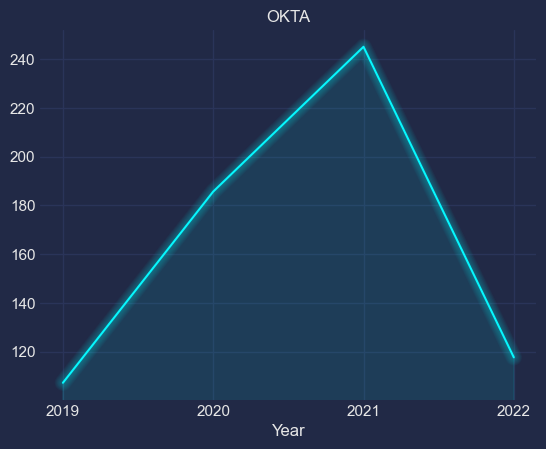

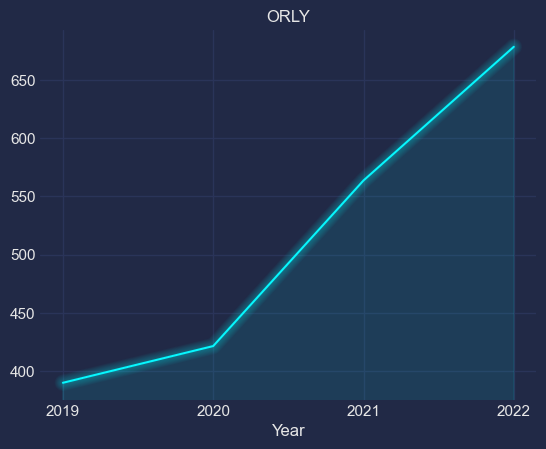

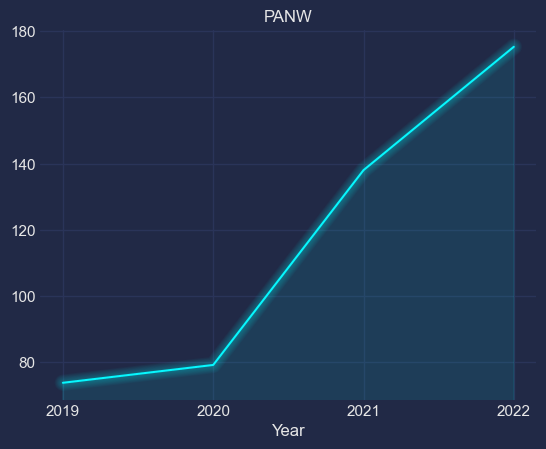

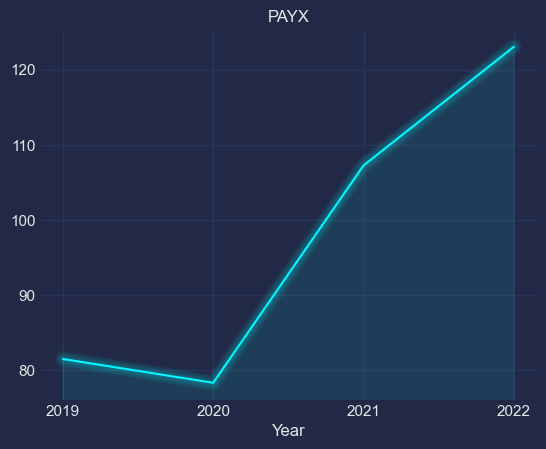

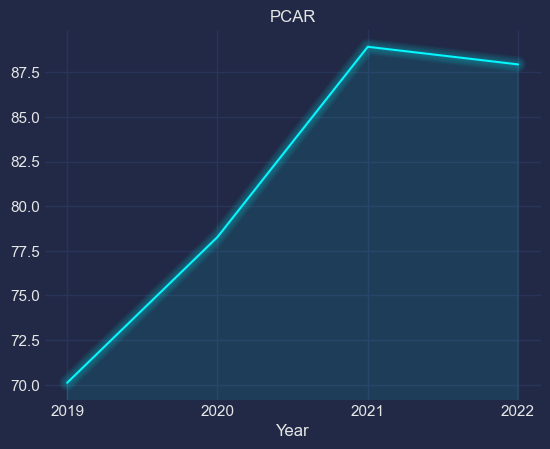

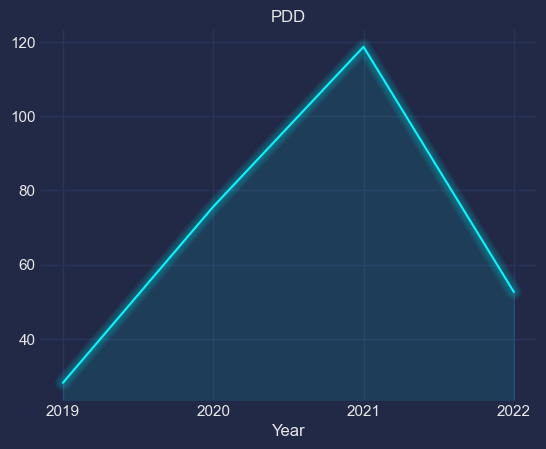

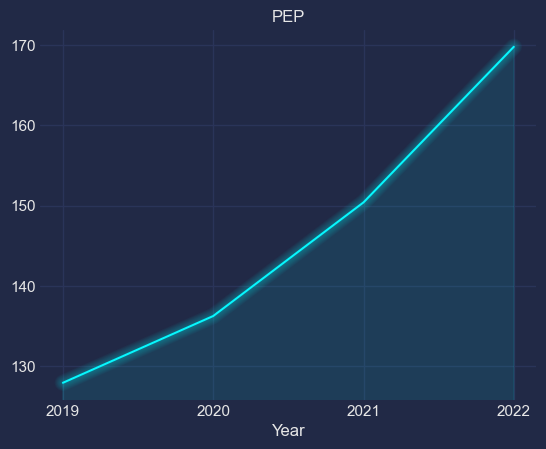

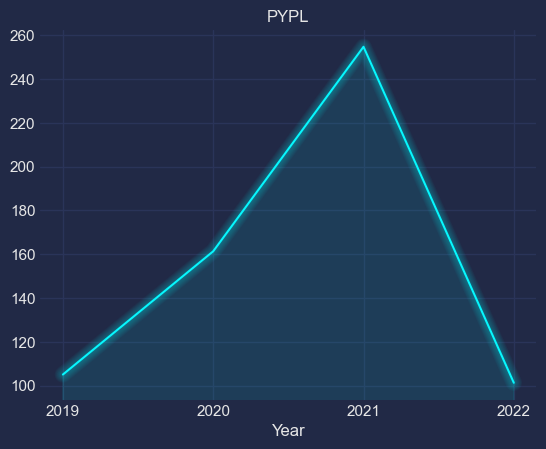

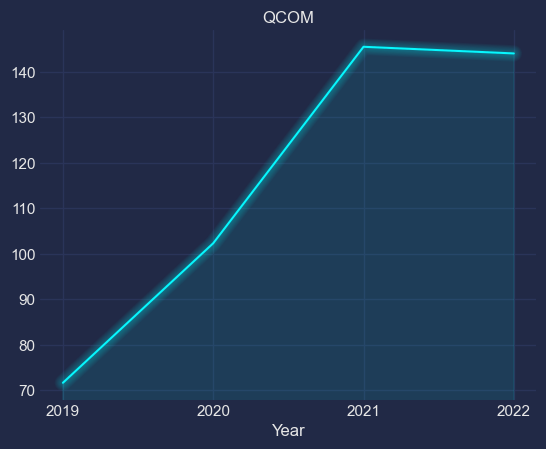

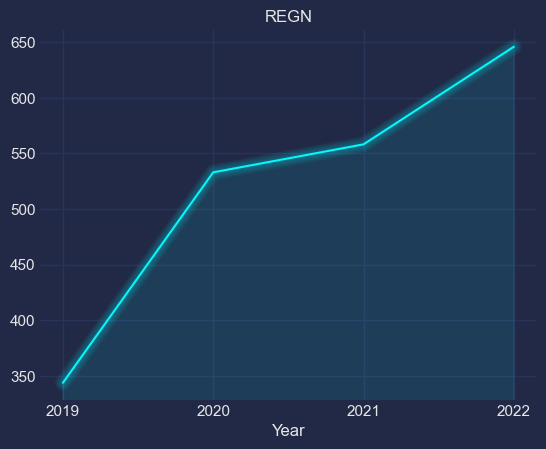

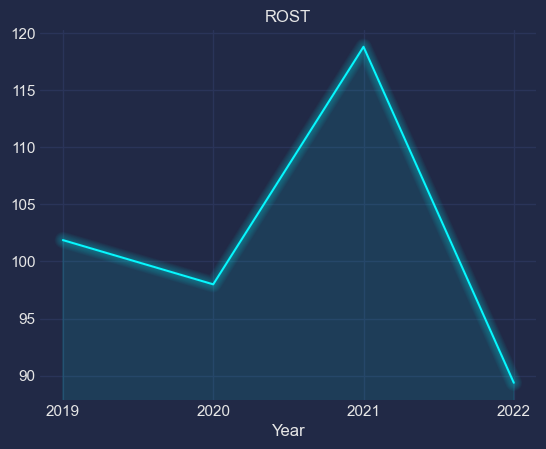

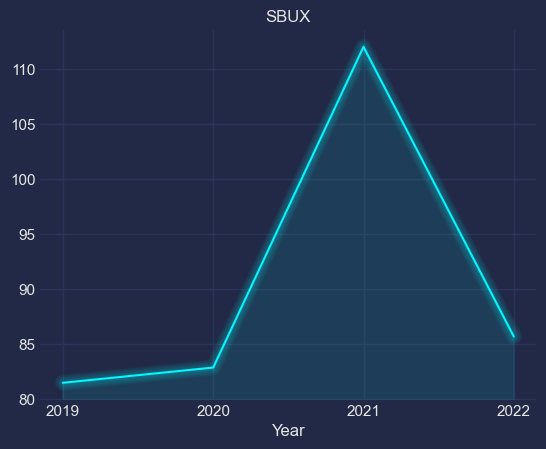

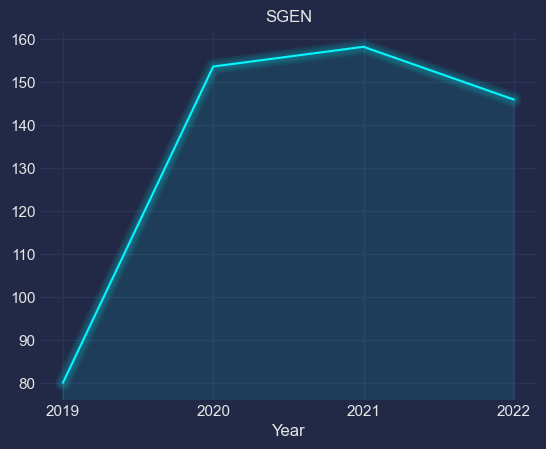

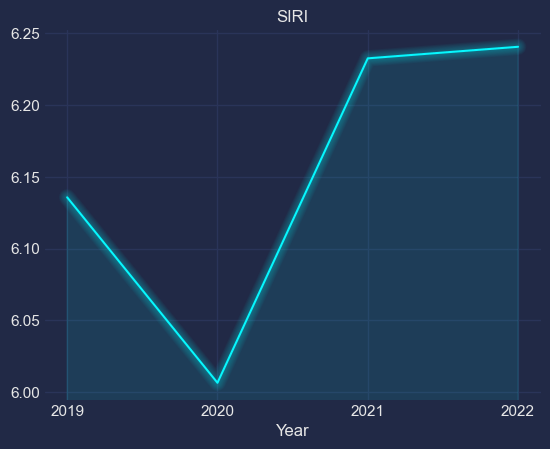

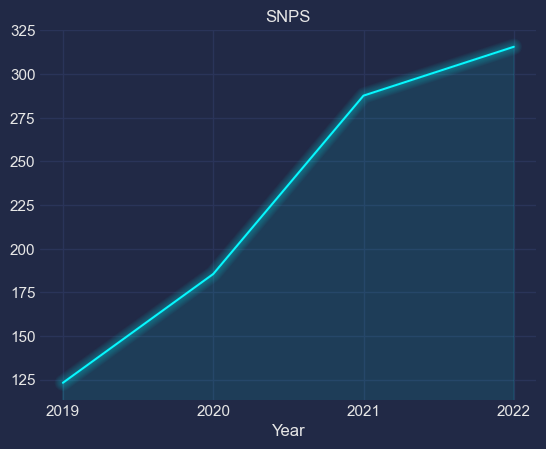

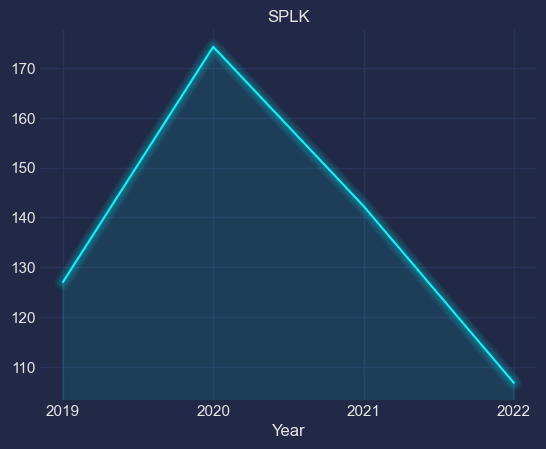

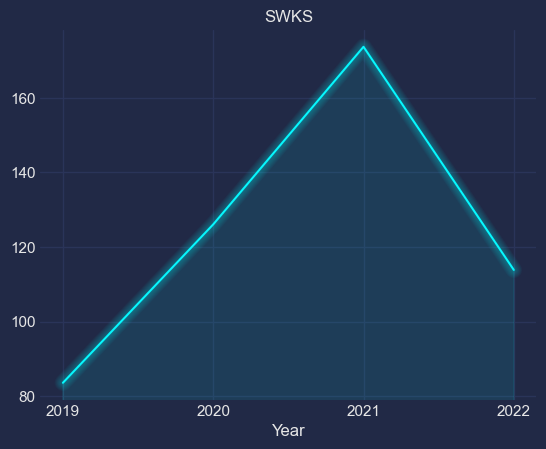

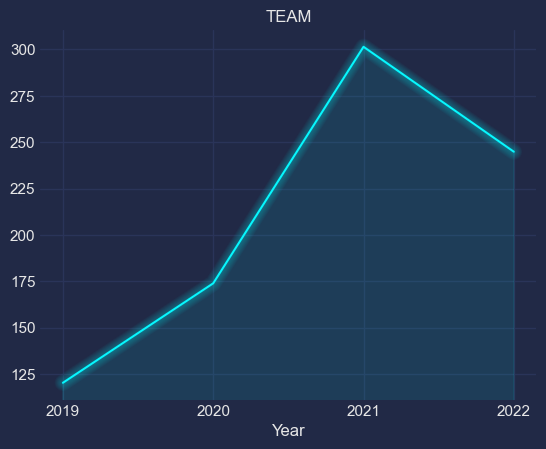

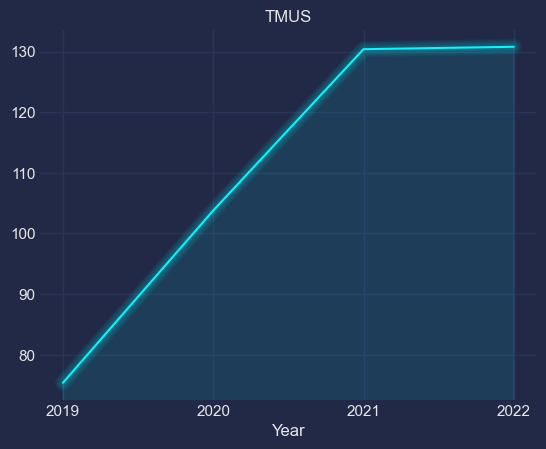

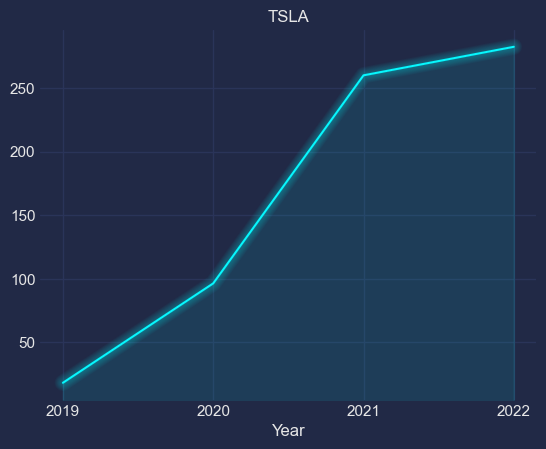

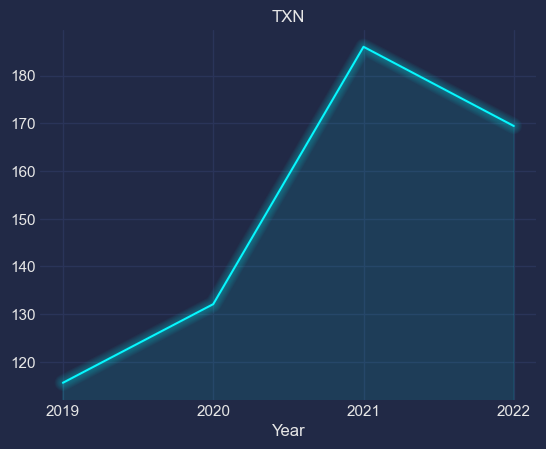

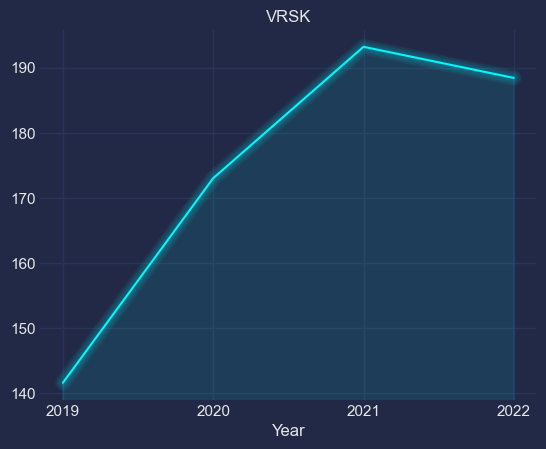

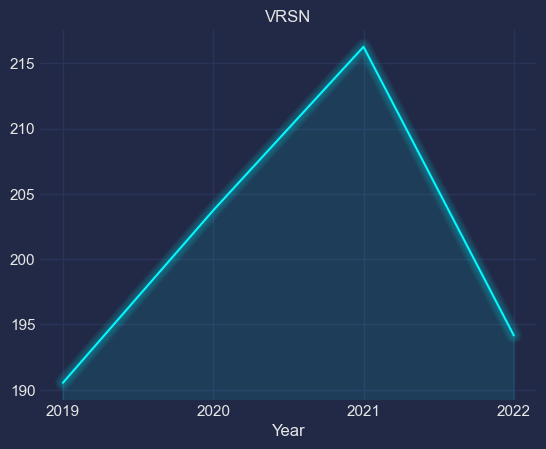

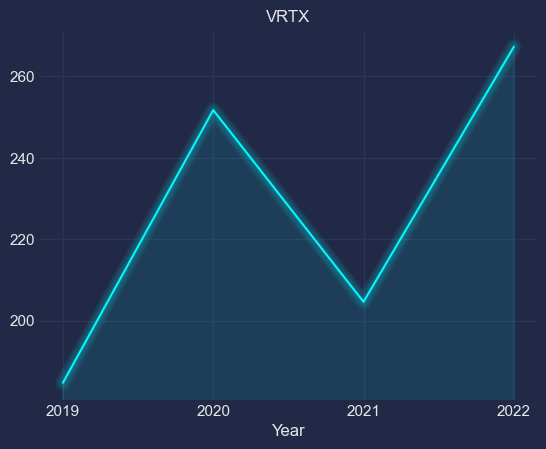

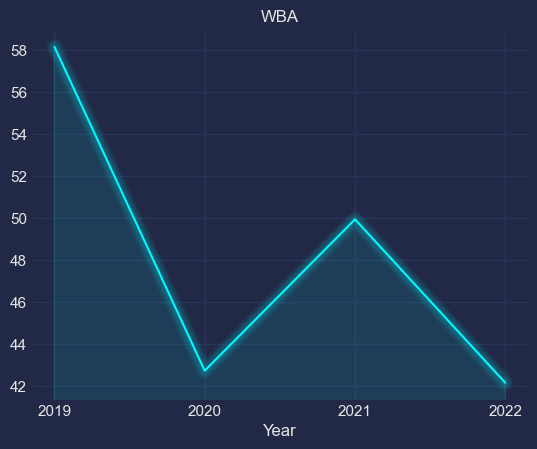

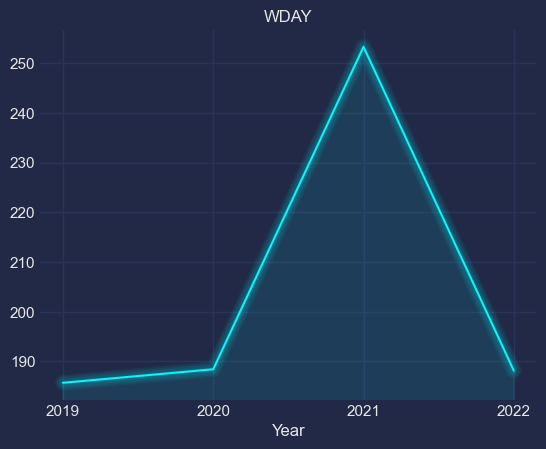

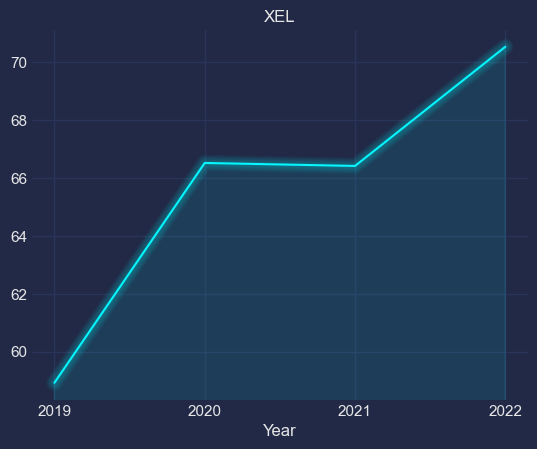

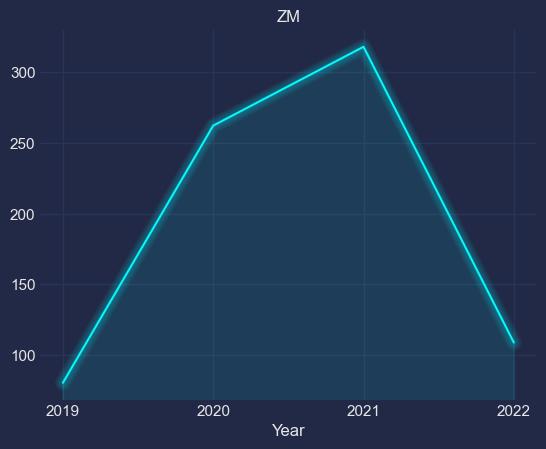

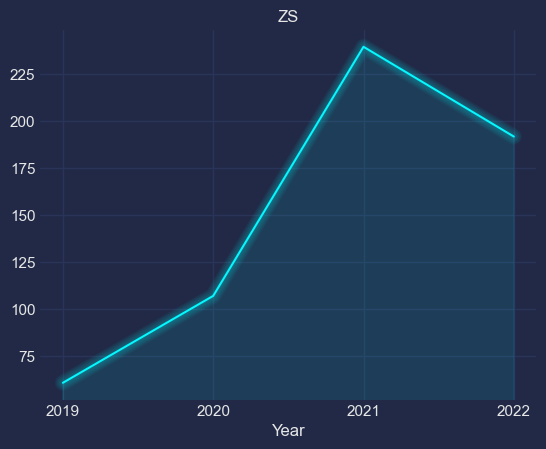

Empty DataFrame
Columns: []
Index: []

In [335]:
# Visualizing the stock opening mean of the year to incline or decline over the year 2019 and 2021
# The strategy I am using was if it was decline. It was effect by COVID 19
master_stock.groupby('Symbol').apply(plot_line)

In [239]:
# Checking the company which is affect by COVID-19 using bar chart

def tmp(X):
    tmp=X.copy()
    tmp['Year']=tmp['Date'].dt.year
    tmp=tmp[(tmp['Year']>=2019) & (tmp['Year']<=2020)]
    tmp['covid_impact'] = (tmp['Close'] - tmp['Close'].shift(252)) / tmp['Close'].shift(252)
    return np.mean(tmp['covid_impact'])

In [240]:
# Get the company
symbol=master_stock.groupby('Symbol').apply(tmp)

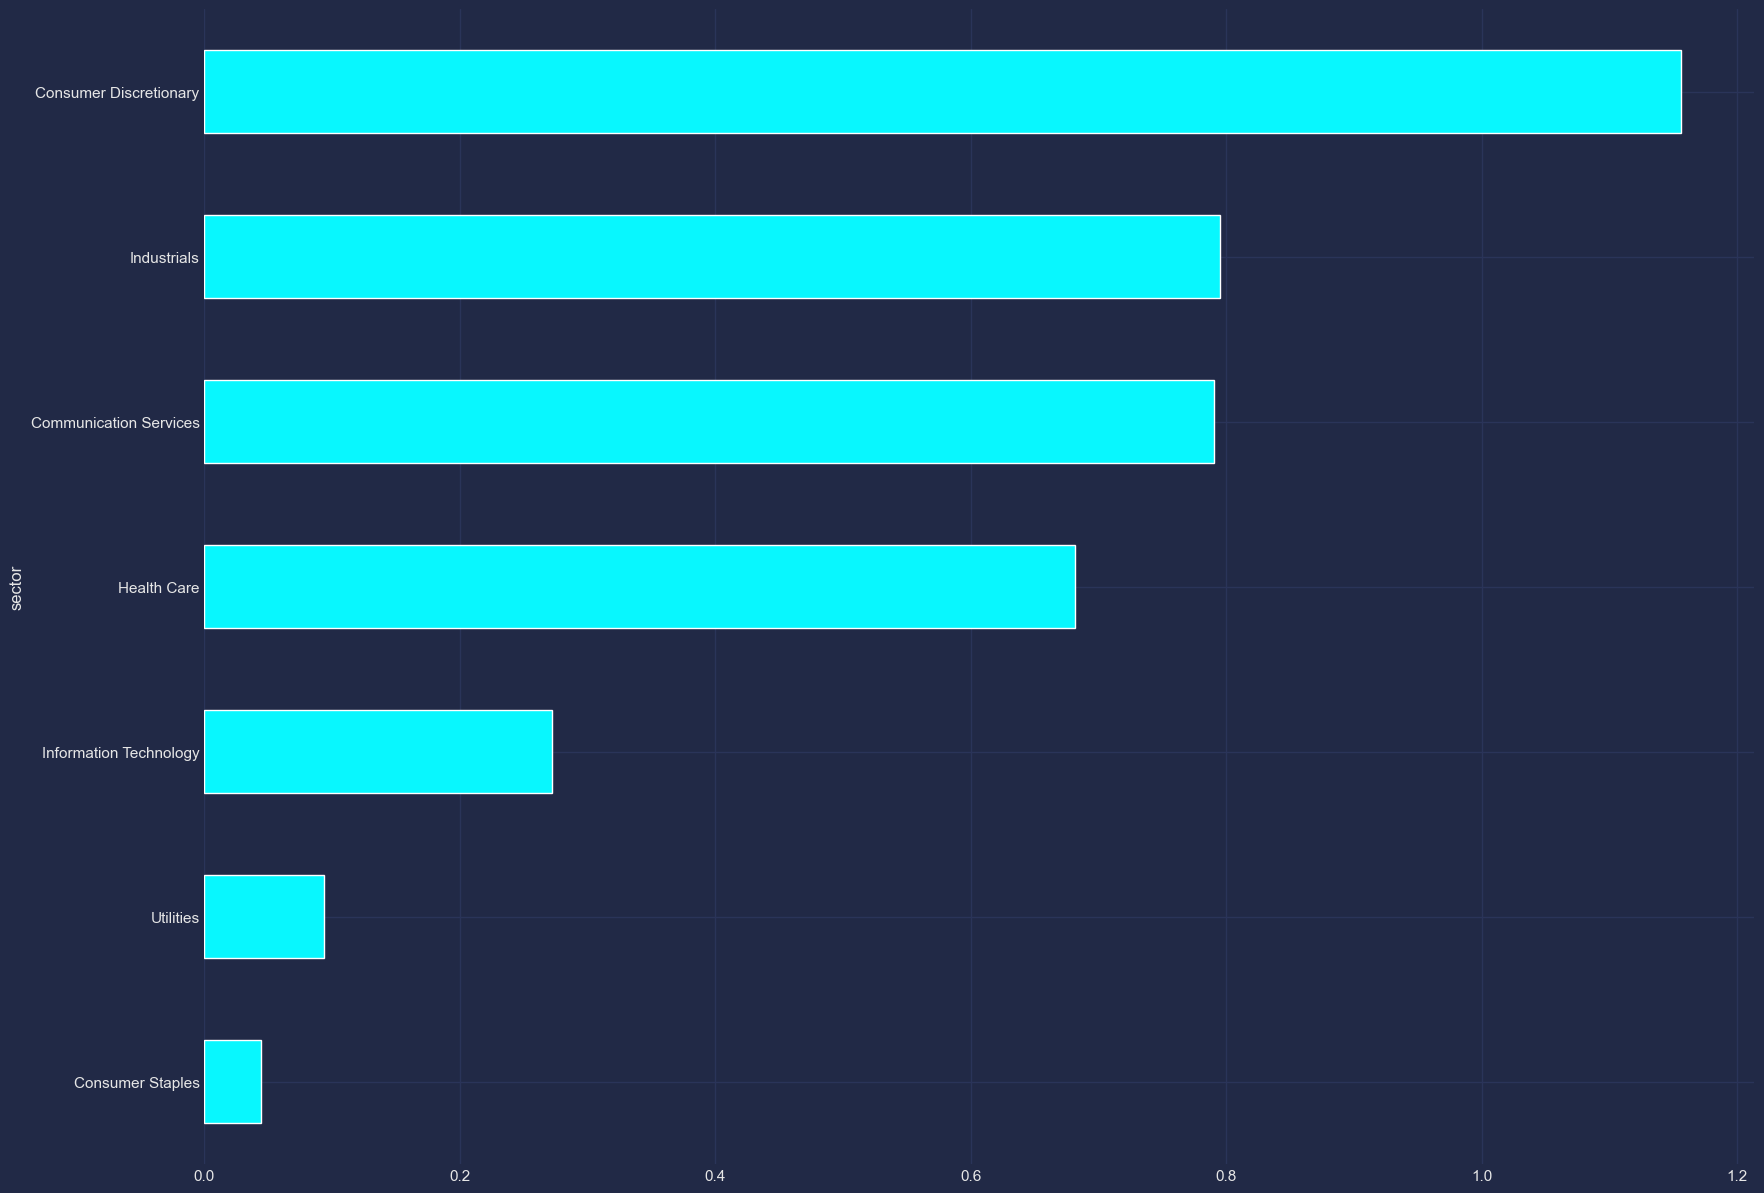

In [314]:
plt.figure(figsize=(20,15))
symbol.sort_values().plot(kind='barh')
save_plots(f'Company affect by Covid')
save_plots(f'Company affect by Covid')
plt.show()

- Company that are affect by COVD-19 are
    - Walgreens Boots Alliance
    - Marriott International
    - Exelon Utilities
    - Cisco Information Technology
    - **Among them Walgreens (WBA) affect the most**
- Company that are not much affected by COVID-19 are
    - Tesla Inc.
    - Zoom Video Communications
    - Moderna
    - DocuSign
    - Datadog
    - **Among them Tesla Inc.(TSLA) and Zoom Video (ZM) was mostly not affected the COVID-19**

In [242]:
def plot_line(sector):
    df=sector.copy()
    sect=sector['sector'].iloc[0]
    df['Year']=df['Date'].dt.year
    df=df[df['Date'].dt.year>=2019]
    df=df.groupby('Year')['Open'].mean()
    df.plot()
    plt.title(sect)
    plt.xticks(df.index.astype(int))
    save_plots(f' Sector affected by Covid {sect}')
    mplcyberpunk.add_glow_effects()
    plt.show()

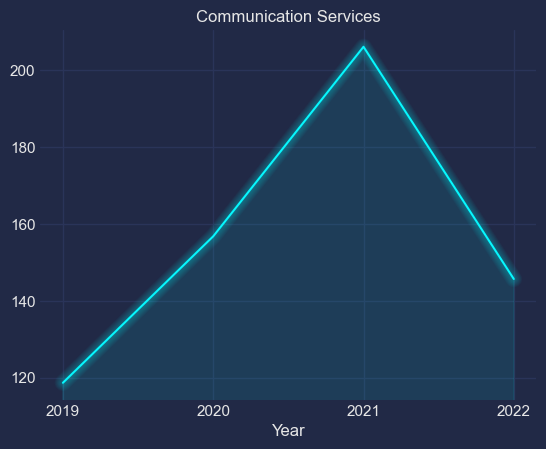

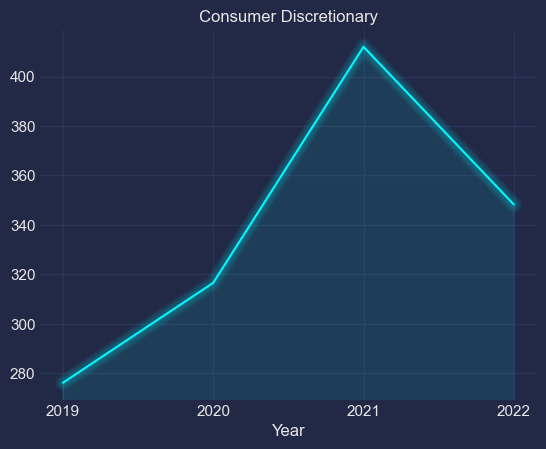

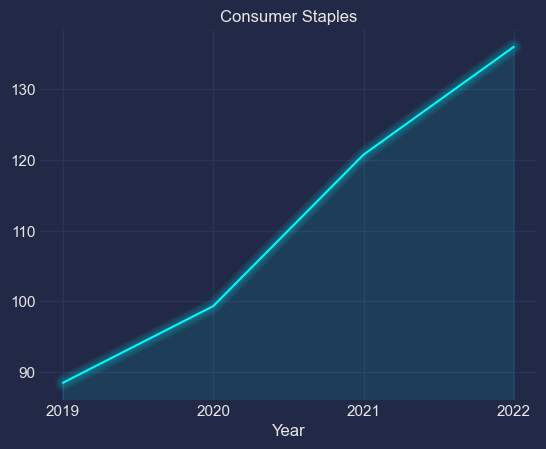

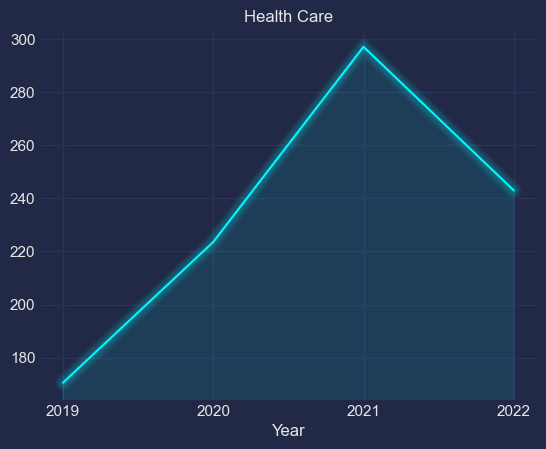

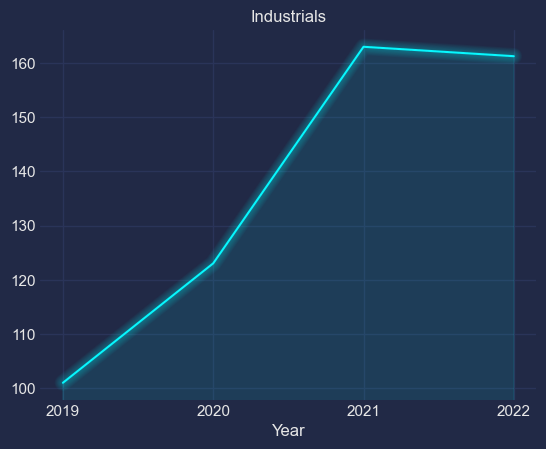

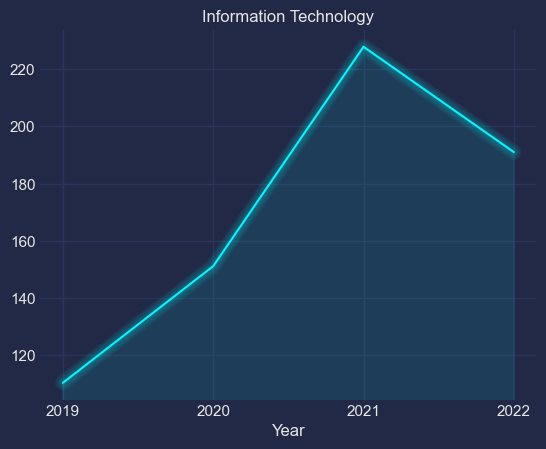

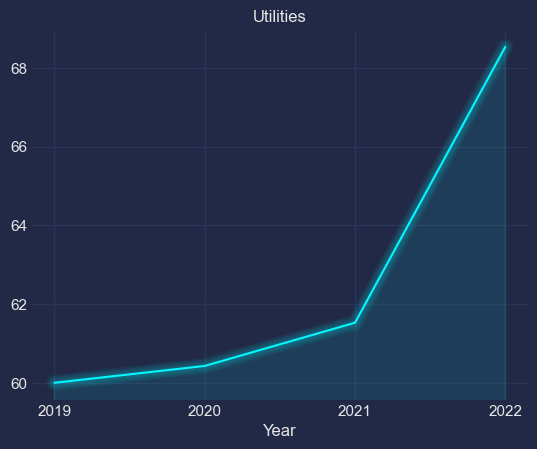

Empty DataFrame
Columns: []
Index: []

In [315]:
master_stock.groupby('sector').apply(plot_line)

In [244]:
def tmp(X):
    tmp=X.copy()
    tmp['Year']=tmp['Date'].dt.year
    tmp=tmp[(tmp['Year']>=2019) & (tmp['Year']<=2020)]
    tmp['covid_impact'] = (tmp['Close'] - tmp['Close'].shift(252)) / tmp['Close'].shift(252)
    return np.mean(tmp['covid_impact'])

In [245]:
symbol=master_stock.groupby('sector').apply(tmp)

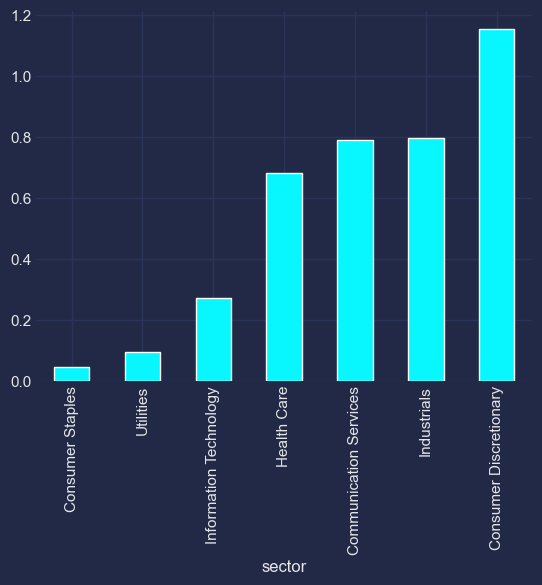

In [316]:
symbol.sort_values().plot(kind='bar')
save_plots('Sector affect by COVID-19')
plt.show()

- **Consumer Staples** sector heat the most followed by **Utilities** and **Information Technology**
- The **Consumer Discretionary** was not much affected

- Observations
    - The company that are not much affect by the COVID-19 are promisable for the future also as it has some hidden potential. So we can invest on this company

# Machine Learning

In [247]:
ml_df=master_df.copy()

In [248]:
# Removing the symbol and company
ml_df=ml_df.iloc[:,2:]
ml_df.dtypes

sector                        object
subsector                     object
asset_turnover_2017          float64
asset_turnover_2018          float64
asset_turnover_2019          float64
                              ...   
yoy_revenue_growth_2020      float64
yoy_revenue_growth_2021      float64
yoy_revenue_growth_latest    float64
Market Cap                     int64
Last Sale                     object
Length: 241, dtype: object

In [249]:
ml_df.dtypes.value_counts()

float64    235
object       3
int64        3
dtype: int64

In [250]:
# Removing the , as change it to float for the Last Sale
ml_df['Last Sale']=[float(x[1:].replace(',','')) for x in ml_df['Last Sale'].values]

In [251]:
le=LabelEncoder()
ml_df['sector']=le.fit_transform(ml_df['sector'])
ml_df['subsector']=le.fit_transform(ml_df['subsector'])

In [252]:
ml_df.head()

sector  subsector  asset_turnover_2017  asset_turnover_2018  \
0       5         38                0.660                 0.72   
1       1         23                0.825                 0.55   
2       5          2                0.540                 0.54   
3       5         34                0.360                 0.30   
4       5         10                0.555                 0.34   

   asset_turnover_2019  asset_turnover_2020  asset_turnover_2021  \
0                 0.74                 0.83                 1.08   
1                 0.64                 0.36                 0.50   
2                 0.57                 0.57                 0.61   
3                 0.29                 0.26                 0.20   
4                 0.34                 0.35                 0.33   

   asset_turnover_latest  buyback_yield_2017  buyback_yield_2018  ...  \
0                   0.24            4.090000                6.71  ...   
1                   0.12            2.035574                6.03  ...   
2                   0.17            1.080000                1.52  ...   
3                   0.06            0.140000                0.73  ...   
4                   0.06            2.035574                1.68  ...   

   yoy_eps_growth_2021  yoy_eps_growth_latest  yoy_revenue_growth_2017  \
0                71.04                  -7.69                   11.340   
1                96.46                 609.09                   23.355   
2                -7.48                  -3.97                   25.510   
3                 5.49                   6.67                   36.640   
4                 6.49                  19.05                   12.900   

   yoy_revenue_growth_2018  yoy_revenue_growth_2019  yoy_revenue_growth_2020  \
0                    21.69                     5.36                    11.94   
1                    40.08                    31.58                    31.27   
2                    24.45                    25.21                    16.86   
3                    10.91                    -3.22                    -6.25   
4                     8.65                     7.16                     4.84   

   yoy_revenue_growth_2021  yoy_revenue_growth_latest     Market Cap  \
0                    38.50                       5.11  2625740143000   
1                   -18.11                      41.00    69569944167   
2                    23.69                      15.54   149144569000   
3                    21.07                      26.30    75484763090   
4                     4.95                      12.02    98332762096   

   Last Sale  
0     151.45  
1     116.65  
2     320.81  
3     146.76  
4     236.78  

[5 rows x 241 columns]

In [253]:
scaler=StandardScaler()
ml_df_scaled=pd.DataFrame(scaler.fit_transform(ml_df),columns=ml_df.columns)

## Perform PCA to reduce the number of variables in the data

##### Frist I performed pca with 3 component for easy visualization for the cluster and after that we can use elbo graph to identify the right number of pca

In [254]:
pca=PCA(n_components=3)

In [255]:
ml_df_pca=pd.DataFrame(pca.fit_transform(ml_df_scaled))
ml_df_pca.columns=['PCA'+str(x+1) for x in range(3)]

In [256]:
# Using wcss to find the right number of cluster
WCSSKmeansOut = pd.DataFrame(columns=['Clusters','WCSSErrorScore'])
clusters=[]
wcssErrorScore=[]
for loopCounter in range(1,14):
    kmeans = KMeans(n_clusters=loopCounter,random_state=1, init='k-means++')
    kmeans.fit(ml_df_pca)
#     WCSSKmeansOut = WCSSKmeansOut.append({'Clusters': loopCounter,'WCSSErrorScore' : kmeans.inertia_},ignore_index=True)
    clusters.append(loopCounter)
    wcssErrorScore.append(kmeans.inertia_)
WCSSKmeansOut['Clusters']=clusters
WCSSKmeansOut['WCSSErrorScore']=wcssErrorScore
WCSSKmeansOut.set_index('Clusters',inplace=True)
WCSSKmeansOut

C:\Users\rajal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



WCSSErrorScore
Clusters                
1            6162.232515
2            4281.625298
3            2911.186428
4            1864.593883
5            1461.751056
6            1155.138562
7             954.633445
8             788.379374
9             658.270436
10            571.411585
11            514.615644
12            472.107768
13            435.160045

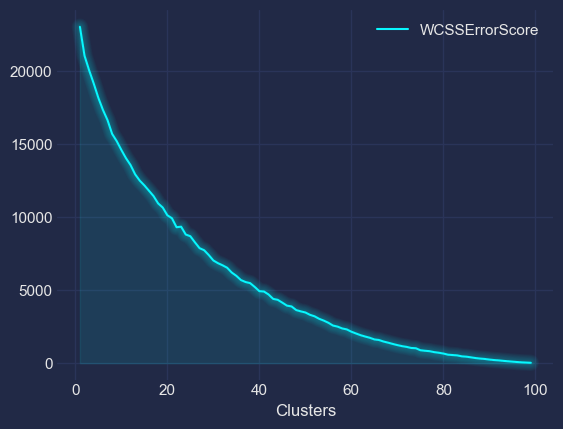

In [317]:
WCSSKmeansOut.plot()
mplcyberpunk.add_glow_effects()
save_plots('WCSS Cluster')
plt.show()

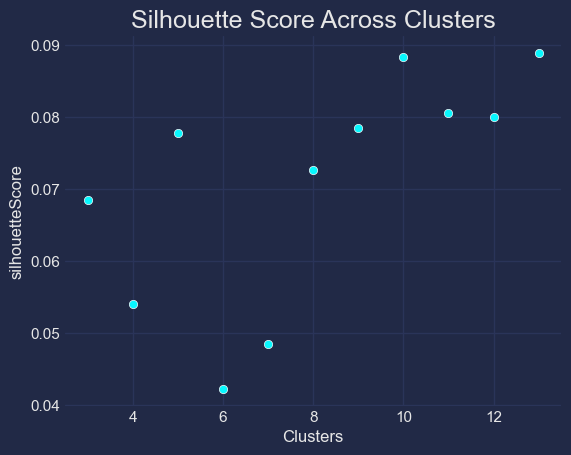

In [318]:
# Validate using silhouette Score

#Optimum Cluster # Validation using Silhouette Score
#Using 3 as lower range number as typically best score for Silhouette is obtained for 2 clusters 
#With 13 segments selected - 2 clusters is not ideal
WCSSKmeansSilhouetteOut = pd.DataFrame(columns=['Clusters','silhouetteScore'])
clusters=[]
silhouetteScore_=[]
for loopCounter2 in range(3,14):
    SilhouetteKMeansModel = KMeans(n_clusters=loopCounter2, random_state=1,init='k-means++').fit(ml_df_pca)
    preds = SilhouetteKMeansModel.predict(ml_df_pca)
    silhouetteScore = silhouette_score(ml_df_pca,preds)
    clusters.append(loopCounter2)
    silhouetteScore_.append(silhouetteScore)
WCSSKmeansSilhouetteOut['Clusters']=clusters
WCSSKmeansSilhouetteOut['silhouetteScore']=silhouetteScore_
# plot Silhouette graph
ax4 = sns.scatterplot(x="Clusters", y="silhouetteScore", data=WCSSKmeansSilhouetteOut)
# Set title
plt.title('Silhouette Score Across Clusters',fontsize=18)
save_plots('Silhouette Score Across Clusters')
mplcyberpunk.add_glow_effects()
plt.show()

- The number of cluster was 4

In [259]:
ComputedClusters = 4

#Build KMeans Model with 4 Clusters
KMeansModel = KMeans(n_clusters=ComputedClusters, random_state=1, init='k-means++')
KMeansModel.fit(ml_df_pca)
clusterLabels = KMeansModel.labels_
clusterLabels

array([0, 3, 1, 0, 0, 3, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 3, 0, 0, 0, 1, 3, 0, 3, 3, 1, 0, 0, 1, 0, 3, 0, 1, 1,
       0, 3, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 3, 1, 1, 1, 1, 0,
       0, 1, 3, 1, 1, 0, 1, 3, 0, 3, 0, 0, 3, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       3, 1, 3, 0, 3, 1, 0, 3, 1, 0, 3, 0, 1, 3])

In [260]:
# Asigning the cluster column to the ml_df dataframe for visualization
cluster1_df=ml_df_pca.assign(Cluster=clusterLabels)
# Asigning the cluster column to the master_df for cluster analysis
master_df_cluster1=master_df[['Symbol', 'company', 'sector', 'subsector','financial_strength_latest','profitability']].assign(Cluster=clusterLabels)
cluster1_df.head()

PCA1      PCA2      PCA3  Cluster
0  2.988732 -2.488859 -2.127236        0
1  0.997596  4.256680  0.092303        3
2 -3.978791  1.381517 -2.067842        1
3  0.290912 -3.484109  0.113477        0
4  1.579918 -1.253434 -0.753719        0

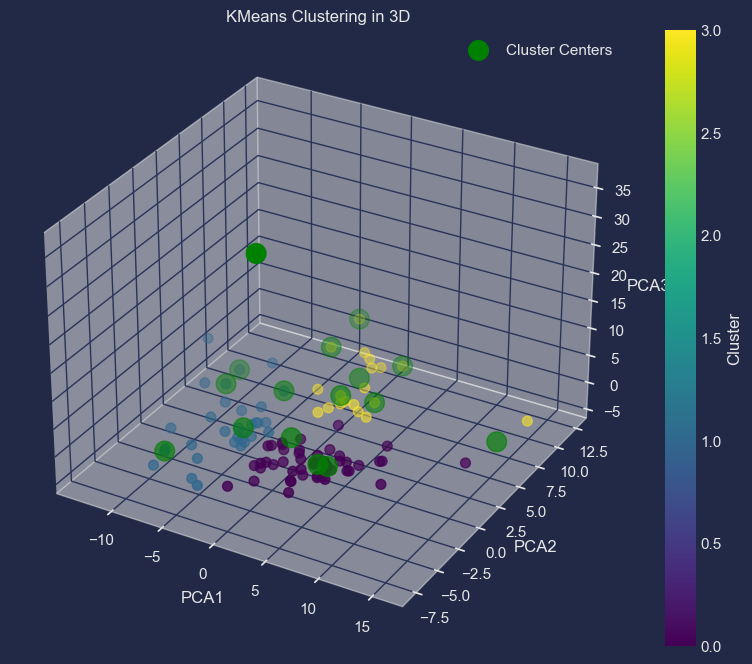

In [319]:
# Visualize the clusters in 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points with colors representing clusters
scatter = ax.scatter(cluster1_df.iloc[:, 0], cluster1_df.iloc[:, 1], cluster1_df.iloc[:, 2], c=cluster1_df['Cluster'], cmap='viridis', s=50)

# Plot the cluster centers
ax.scatter(KMeansModel.cluster_centers_[:, 0], KMeansModel.cluster_centers_[:, 1], KMeansModel.cluster_centers_[:, 2],
           marker='o', s=200, color='green', label='Cluster Centers')

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('KMeans Clustering in 3D')
ax.legend()

# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster')
save_plots('Cluster')
plt.show()

In [262]:
# Performing pca by selecting the component using elbow graph
pca = PCA()
pca.fit(ml_df_scaled)

PCA()

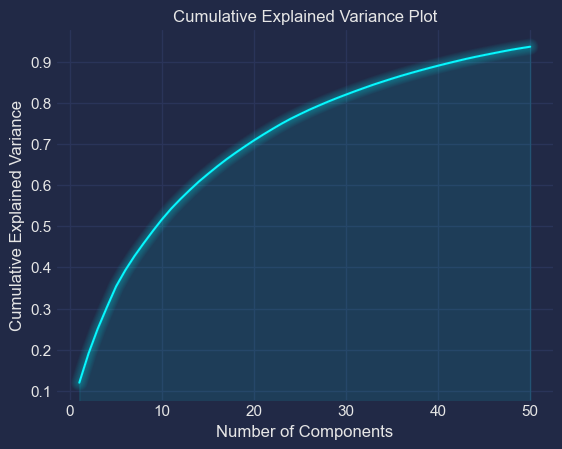

In [320]:
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance

plt.plot(range(1,
               len(cum_explained_variance) + 1),
         cum_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
save_plots('Cumulative Explained Variance Plot')
mplcyberpunk.add_glow_effects()
plt.show()

In [264]:
# The curved is saturated at 50.
# So lets take the the number of component as 50
pca=PCA(n_components=50)
ml_df_pca=pd.DataFrame(pca.fit_transform(ml_df_scaled))
# ml_df_pca.columns=['PCA'+str(x+1) for x in range(60)]

In [265]:
ml_df_pca.head()

0         1         2         3         4         5         6   \
0  2.988732 -2.488859 -2.127236  0.493559 -3.420989  3.346869  0.176626   
1  0.997596  4.256680  0.092303  0.797678 -0.998179  0.200725 -0.929324   
2 -3.978791  1.381517 -2.067842 -1.482110  0.376478 -1.440282 -0.549163   
3  0.290912 -3.484109  0.113477  2.057986  2.870002 -3.888770 -1.140713   
4  1.579918 -1.253434 -0.753719  1.452216 -1.266643  0.907034 -1.811315   

         7         8         9   ...        40        41        42        43  \
0 -2.551219 -1.217042 -0.068201  ... -2.212530  0.148568  0.341977 -1.521482   
1 -0.320647  2.434916 -0.644546  ...  0.562554 -1.108329  0.332809 -0.718870   
2 -1.105177  0.004340 -1.472310  ... -0.895313 -0.531419 -0.075126  0.215779   
3  0.004890  1.083275  0.557398  ... -0.722614 -0.060316 -0.965529 -0.062177   
4  0.791451  1.368938 -2.010047  ...  0.545735 -0.220954  1.526676 -0.326560   

         44        45        46        47        48        49  
0 -0.272431 -0.986883  0.801757 -1.022787  0.004623 -0.132263  
1  2.686508 -0.317118 -1.848799 -0.418604 -0.402638 -1.138396  
2 -0.439056 -0.716214  0.179394 -0.500698  0.030844 -0.225251  
3  0.076461 -2.057354  0.756373  0.744652 -1.596614  0.902847  
4  0.318956 -0.703061  0.283525 -0.623062 -0.512129 -0.024832  

[5 rows x 50 columns]

In [266]:
WCSSKmeansOut = pd.DataFrame(columns=['Clusters','WCSSErrorScore'])
# Choose range of 1 to 14 as we have 13 Customer Segments
clusters=[]
wcssErrorScore=[]
for loopCounter in range(1,100):
    kmeans = KMeans(n_clusters=loopCounter,random_state=1, init='k-means++')
    kmeans.fit(ml_df_pca)
#     WCSSKmeansOut = WCSSKmeansOut.append({'Clusters': loopCounter,'WCSSErrorScore' : kmeans.inertia_},ignore_index=True)
    clusters.append(loopCounter)
    wcssErrorScore.append(kmeans.inertia_)
WCSSKmeansOut['Clusters']=clusters
WCSSKmeansOut['WCSSErrorScore']=wcssErrorScore
WCSSKmeansOut.set_index('Clusters',inplace=True)
WCSSKmeansOut.head()

C:\Users\rajal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



WCSSErrorScore
Clusters                
1           23033.080345
2           21054.638937
3           20056.810861
4           19149.821961
5           18175.286797

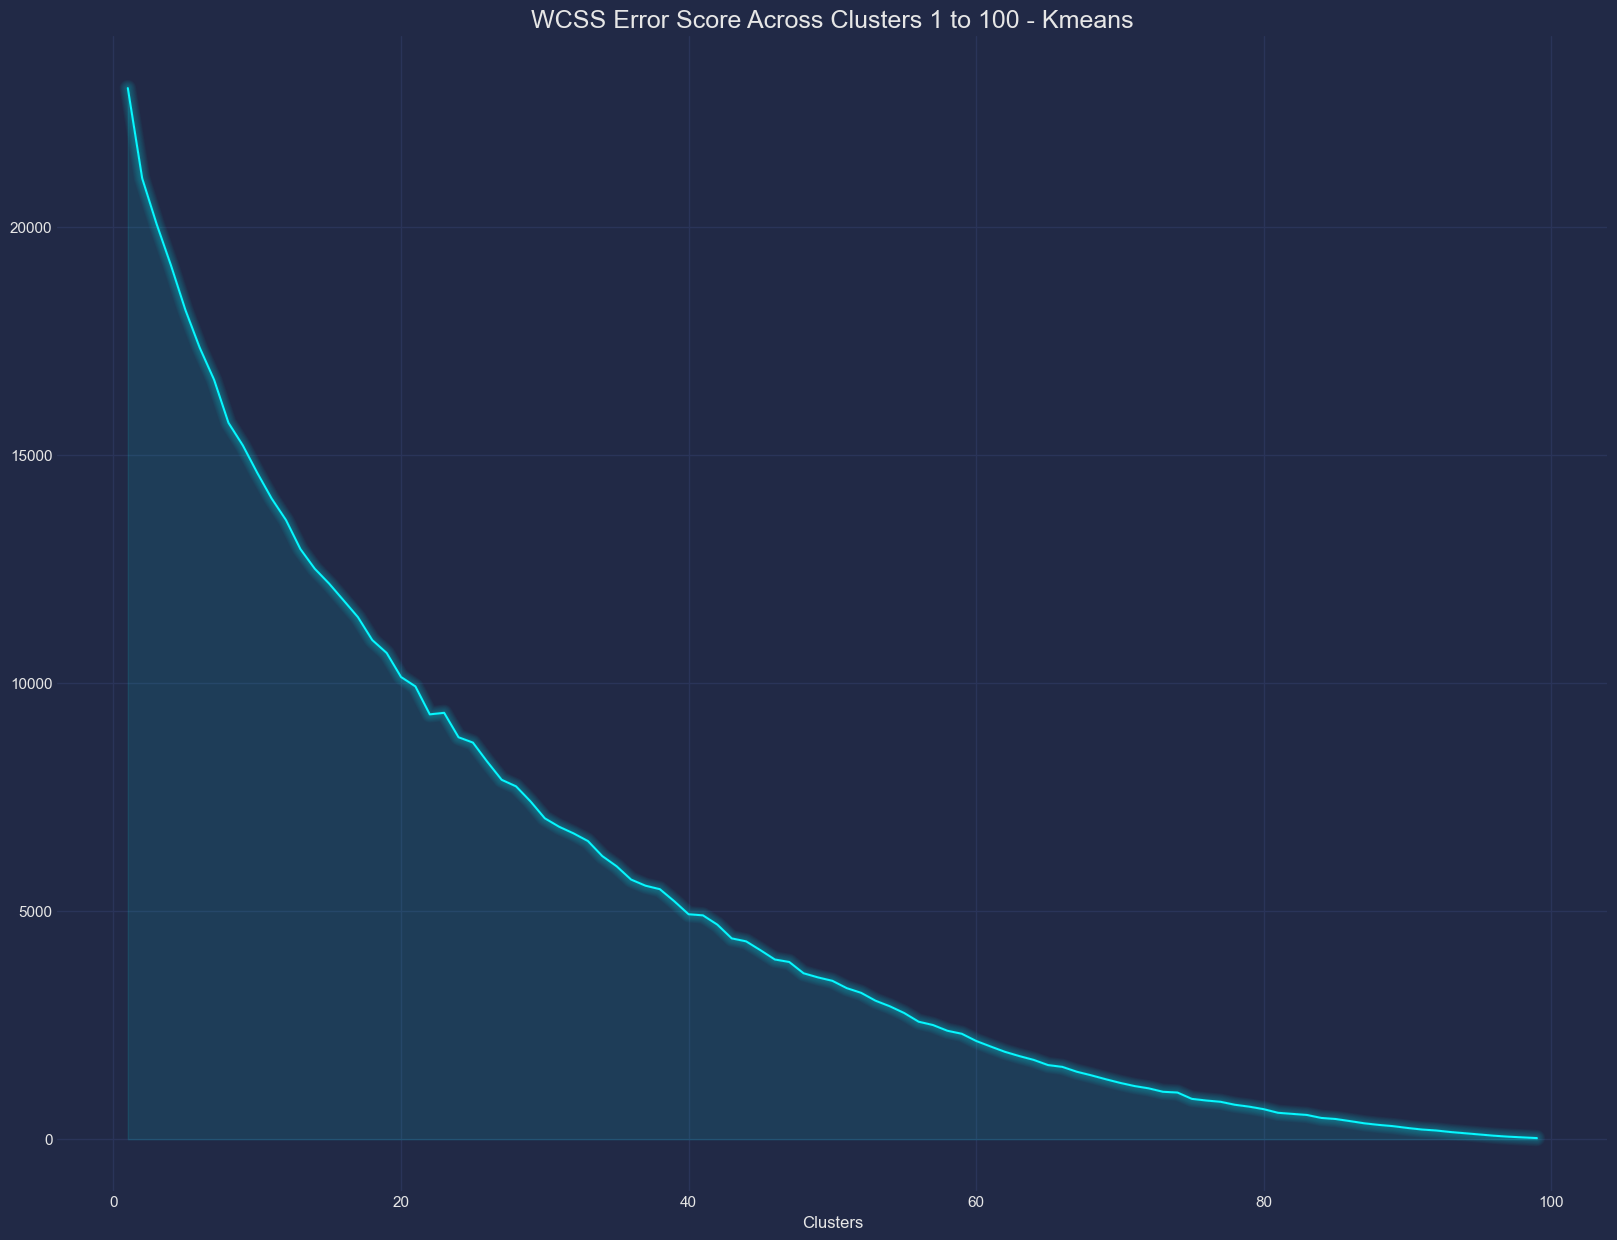

In [337]:
# Plot WCSS Elbow Graph
plt.figure(figsize=(20,15));
plt.title('WCSS Error Score Across Clusters 1 to 100 - Kmeans',fontsize=18)
WCSSKmeansOut.WCSSErrorScore.plot()
save_plots('WCSS Error Score Across Clusters 1 to 100 - Kmeans')
mplcyberpunk.add_glow_effects()
plt.show()

In [268]:
# Validate using silhouette Score

#Optimum Cluster # Validation using Silhouette Score
#Using 3 as lower range number as typically best score for Silhouette is obtained for 2 clusters 
#With 13 segments selected - 2 clusters is not ideal
WCSSKmeansSilhouetteOut = pd.DataFrame(columns=['Clusters','silhouetteScore'])
clusters=[]
silhouetteScore_=[]
for loopCounter2 in range(3,100):
    SilhouetteKMeansModel = KMeans(n_clusters=loopCounter2, random_state=1,init='k-means++').fit(ml_df_pca)
    preds = SilhouetteKMeansModel.predict(ml_df_pca)
    silhouetteScore = silhouette_score(ml_df_pca,preds)
    clusters.append(loopCounter2)
    silhouetteScore_.append(silhouetteScore)
WCSSKmeansSilhouetteOut['Clusters']=clusters
WCSSKmeansSilhouetteOut['silhouetteScore']=silhouetteScore_

In [269]:
# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=WCSSKmeansSilhouetteOut['Clusters'], y=WCSSKmeansSilhouetteOut['silhouetteScore'], mode='markers'))

# Update layout (optional)
fig.update_layout(title='Scatter Plot Example', xaxis_title='X-axis Label', yaxis_title='Y-axis Label')

# Show the plot
fig.show()

In [270]:
# Frome the above graph we can take the number of cluster as 16
ComputedClusters = 16
#Build KMeans Model with 16 Clusters
KMeansModel = KMeans(n_clusters=ComputedClusters, random_state=1, init='k-means++')
KMeansModel.fit(ml_df_pca)
clusterLabels = KMeansModel.labels_
clusterLabels

array([ 1,  2,  2,  1,  1,  1,  1,  2,  2, 13,  1,  5,  2,  2,  2,  1,  1,
        1,  1, 12,  2,  1,  1,  1,  5,  2,  0,  1,  1,  1,  2,  9,  1,  0,
       15,  2,  1,  1,  2,  1,  2,  1,  4,  4,  1,  2,  2,  1,  2,  2,  5,
        1,  1,  1,  7,  2,  2,  1,  1,  1, 11,  2,  2,  8,  2,  2,  1,  2,
        5,  2,  2,  1,  2,  0,  1, 14,  1,  1,  2,  1,  2,  1,  2,  5,  1,
        2,  3,  2,  0,  2,  0,  1,  6,  2,  1,  3, 10,  1,  0,  1,  2,  0])

In [271]:
# Asigning the cluster column to the ml_df dataframe for visualization
cluster2_df=ml_df_pca.assign(Cluster=clusterLabels)
# Asigning the cluster column to the master_df dataframe for cluster analysis
master_df_cluster2=master_df[['Symbol', 'company', 'sector', 'subsector','financial_strength_latest','profitability']].assign(Cluster=clusterLabels)
cluster2_df.head()

0         1         2         3         4         5         6  \
0  2.988732 -2.488859 -2.127236  0.493559 -3.420989  3.346869  0.176626   
1  0.997596  4.256680  0.092303  0.797678 -0.998179  0.200725 -0.929324   
2 -3.978791  1.381517 -2.067842 -1.482110  0.376478 -1.440282 -0.549163   
3  0.290912 -3.484109  0.113477  2.057986  2.870002 -3.888770 -1.140713   
4  1.579918 -1.253434 -0.753719  1.452216 -1.266643  0.907034 -1.811315   

          7         8         9  ...        41        42        43        44  \
0 -2.551219 -1.217042 -0.068201  ...  0.148568  0.341977 -1.521482 -0.272431   
1 -0.320647  2.434916 -0.644546  ... -1.108329  0.332809 -0.718870  2.686508   
2 -1.105177  0.004340 -1.472310  ... -0.531419 -0.075126  0.215779 -0.439056   
3  0.004890  1.083275  0.557398  ... -0.060316 -0.965529 -0.062177  0.076461   
4  0.791451  1.368938 -2.010047  ... -0.220954  1.526676 -0.326560  0.318956   

         45        46        47        48        49  Cluster  
0 -0.986883  0.801757 -1.022787  0.004623 -0.132263        1  
1 -0.317118 -1.848799 -0.418604 -0.402638 -1.138396        2  
2 -0.716214  0.179394 -0.500698  0.030844 -0.225251        2  
3 -2.057354  0.756373  0.744652 -1.596614  0.902847        1  
4 -0.703061  0.283525 -0.623062 -0.512129 -0.024832        1  

[5 rows x 51 columns]

## After PCA, perform cluster analysis to identify cohorts, define these cohorts (cluster profiling), and specify the insights found
## Highlight companies from different sectors falling into the same cohort, and share your findings

##### Analysing the first cluster i.e 3 cluster

In [272]:
# Making an averate rate for return column row wise
rate_of_return_column=[x for x in master_df.columns if 'rate_of_return' in x]
master_df_cluster1['avg_rate_of_return']=master_df[rate_of_return_column].mean(axis=1)

In [273]:
master_df_cluster1['avg_rate_of_return'].max()

24.095

In [274]:
# Cluster 0
master_df_cluster1[master_df_cluster1['Cluster']==0].sample(10,random_state=2)

Symbol                   company                  sector  \
41   GILD           Gilead Sciences             Health Care   
21    CEG      Constellation Energy               Utilities   
83   ROST               Ross Stores  Consumer Discretionary   
27   CSCO                     Cisco  Information Technology   
71   NXPI                       NXP  Information Technology   
86   SIRI                 Sirius XM  Communication Services   
97    WBA  Walgreens Boots Alliance        Consumer Staples   
22   CHTR    Charter Communications  Communication Services   
23  CMCSA                   Comcast  Communication Services   
0    AAPL                Apple Inc.  Information Technology   

                                     subsector  financial_strength_latest  \
41                               Biotechnology                          5   
21                             Multi-Utilities                          5   
83                              Apparel Retail                          7   
27                    Communications Equipment                          7   
71                              Semiconductors                          5   
86                                Broadcasting                          3   
97                                 Drug Retail                          5   
22                           Cable & Satellite                          3   
23                           Cable & Satellite                          4   
0   Technology Hardware, Storage & Peripherals                          7   

    profitability  Cluster  avg_rate_of_return  
41              8        0            4.575000  
21              3        0            3.565159  
83              8        0            9.338492  
27             10        0           12.536825  
71              8        0           15.311667  
86             10        0           16.870000  
97              8        0            8.835000  
22              8        0           16.541667  
23              9        0           13.203333  
0              10        0           16.085000

##### Findings (Cluster 0)
- This cluster contain company like
    - Gilead Sciences
    - Constellation Energy
    - Ross Stores
    - Cisco
    - NXP
    - Sirius XM
    - Walgreens Boots Alliance
    - Charter Communications
    - Comcast
    - Apple Inc.
- It contain sector such as
    - IT
    - Health Care
    - Communication Services
    - Consumer Staples etc
- Subsector cover
    - Biotechnology
    - Drug Regail Cable & Satellite
    - Technology Hardware
    - Broad casting etc
- Profitability is quite high for this cluster
- Financial Strength some of them are low but overall not so high at average
- And the average rate of return was also intermediate

**Overall this cluster include Communication and consumer services sector and subsector of hardware technology**

In [275]:
master_df_cluster1[master_df_cluster1['Cluster']==1].sample(10,random_state=5)

Symbol                    company                  sector  \
38   FAST                   Fastenal             Industrials   
61   META             Meta Platforms  Communication Services   
12   ANSS                      Ansys  Information Technology   
14   ATVI        Activision Blizzard  Communication Services   
72   ODFL  Old Dominion Freight Line             Industrials   
64   MRVL         Marvell Technology  Information Technology   
46   ILMN             Illumina, Inc.             Health Care   
82   REGN                  Regeneron             Health Care   
9     AMD                        AMD  Information Technology   
93    TXN          Texas Instruments  Information Technology   

                         subsector  financial_strength_latest  profitability  \
38               Building Products                          8             10   
61    Interactive Media & Services                          8             10   
12            Application Software                          8             10   
14  Interactive Home Entertainment                          8              9   
72                        Trucking                          9             10   
64            Application Software                          6              6   
46  Life Sciences Tools & Services                          6              9   
82                   Biotechnology                          8              9   
9                   Semiconductors                          9              6   
93                  Semiconductors                          8             10   

    Cluster  avg_rate_of_return  
38        1           10.223333  
61        1           22.813333  
12        1            9.348333  
14        1           14.196667  
72        1           18.243333  
64        1           16.530159  
46        1           12.508333  
82        1           22.903333  
9         1           14.891825  
93        1           15.330000

##### Findings (Cluster 1)
- This cluster contain company like
    - Fastenal
    - Meta Platforms
    - Ansys
    - Activision Blizzard
    - Old Dominion Freight Line
    - Marvell Technology
    - Illumina, Inc.
    - Regeneron
    - AMD
    - Texas Instruments
- It contain sector such as
    - IT
    - Health Care
    - Communication Services
    - Industrial etc
- Subsector cover
    - Application Software
    - Interactive Median and Services
    - Semiconductors
    - Life Science and Tools Services etc
- Profitability is quite high for this cluster as lots of company in this cluster got maximum profit
- Overall the finalcial strength is high as it range from 8-9
- And the average rate of return was high in average


**Overall this cluster contain IT sector and sebsector of hard ware tools and technology**

In [276]:
master_df_cluster1[master_df_cluster1['Cluster']==2]

Symbol       company                  sector                 subsector  \
54   LCID  Lucid Motors  Consumer Discretionary  Automobile Manufacturers   

    financial_strength_latest  profitability  Cluster  avg_rate_of_return  
54                          5              0        2           11.680159

##### Findings (Cluster 2)
- Interestingly this cluster contain only one company. We can dive deep to this company that how it separates from the rest of the cluster (I think it would be lots of interesting). But for now we can analyse some of it and dive deep later.
    - Lucid Motors
- It contain sector such as
    - Comsumer Discretionary
- Subsector cover
    - Automobile Manufacturers
- Profitability is quite low as it was 0 for this company
- Finalcial strength was medium
- And the average rate of return was at medium

In [277]:
master_df_cluster1[master_df_cluster1['Cluster']==3].sample(10,random_state=2)

Symbol             company                  sector  \
68   NFLX             Netflix  Communication Services   
33   DOCU            DocuSign  Information Technology   
90   TEAM           Atlassian  Information Technology   
1    ABNB              Airbnb  Consumer Discretionary   
73   OKTA          Okta, Inc.  Information Technology   
34   DXCM              DexCom             Health Care   
31   DDOG             Datadog  Information Technology   
5    ADSK            Autodesk  Information Technology   
78    PDD           Pinduoduo  Consumer Discretionary   
45   IDXX  Idexx Laboratories             Health Care   

                             subsector  financial_strength_latest  \
68              Movies & Entertainment                          6   
33                Application Software                          5   
90                Application Software                          5   
1   Internet & Direct Marketing Retail                          7   
73                Application Software                          5   
34               Health Care Equipment                          6   
31                Application Software                          6   
5                 Application Software                          5   
78  Internet & Direct Marketing Retail                          8   
45               Health Care Equipment                          6   

    profitability  Cluster  avg_rate_of_return  
68              9        3           19.005000  
33              3        3           14.891825  
90              5        3           14.891825  
1               1        3           11.680159  
73              3        3           14.891825  
34              4        3           13.283492  
31              2        3           14.891825  
5               6        3           15.301825  
78              4        3           11.680159  
45             10        3           19.163333

##### Findings (Cluster 3)
- This cluster contain company like
    - Netflix
    - DocuSign
    - Atlassian
    - Airbnb
    - Okta, Inc.
    - DexCom
    - Datadog
    - Autodesk
    - Pinduoduo
    - Idexx Laboratories
- It contain sector such as
    - IT
    - Consumer Discretionary
    - Health Care
    - Communication Sertices etc
    
- Subsector cover
    - Application Software
    - Movies and Entertainment
    - Internet & Digital marketing
    - Health Care equipment etc
- Profitability is high fluctuate in this cluster some are quite high and some are quite low
- Overall the finalcial strength is at medium as it range from 5-8
- And the average rate of return was high in average

**Overall this cluster contain IT and Healthcare sector and subsector of Software technolygy and healthcare equipment**

## Plot seasonality, trend, and irregular components over time for the historical stock price of Apple

In [278]:
# Lets load the applet dataset from the NADQ dataset
aapl_stock=pd.read_csv('./dataset/NASDAQ_DATA/AAPL.csv',parse_dates=['Date'])

In [279]:
aapl_stock.head()

Date      High       Low      Open     Close       Volume  Adj Close
0 1999-12-31  0.918527  0.888393  0.901228  0.917969  163811200.0   0.782493
1 2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.851942
2 2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.780115
3 2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.791530
4 2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.723033

In [280]:
aapl_stock.shape

(5745, 7)

In [281]:
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5745 entries, 0 to 5744
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5745 non-null   datetime64[ns]
 1   High       5745 non-null   float64       
 2   Low        5745 non-null   float64       
 3   Open       5745 non-null   float64       
 4   Close      5745 non-null   float64       
 5   Volume     5745 non-null   float64       
 6   Adj Close  5745 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 314.3 KB


In [282]:
aapl_stock.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [283]:
aapl_stock.describe()

High          Low         Open        Close        Volume  \
count  5745.000000  5745.000000  5745.000000  5745.000000  5.745000e+03   
mean     29.423141    28.774319    29.094851    29.111578  4.168004e+08   
std      42.698454    41.689410    42.180176    42.216001  3.874423e+08   
min       0.235536     0.227143     0.231964     0.234286  3.934000e+07   
25%       1.843929     1.791429     1.823214     1.824286  1.446424e+08   
50%      12.633929    12.408571    12.512143    12.520000  3.008292e+08   
75%      33.957500    33.654999    33.775002    33.837502  5.529300e+08   
max     182.940002   179.119995   182.630005   182.009995  7.421641e+09   

         Adj Close  
count  5745.000000  
mean     27.917659  
std      42.050749  
min       0.199710  
25%       1.555054  
50%      10.672275  
75%      31.804134  
max     180.959732

## Based on trend and seasonality, choose an appropriate exponential smoothing method to forecast the weekend share price value for the next 12 months

In [284]:
aapl_stock.sort_values('Date',inplace=True)

In [285]:
aapl_stock.set_index('Date',inplace=True)

In [286]:
y=aapl_stock['Close']

In [287]:
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

In [288]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
fit_model = model.fit()

C:\Users\rajal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [289]:
# Forecast the next 12 months
forecast_values = fit_model.forecast(12)

C:\Users\rajal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



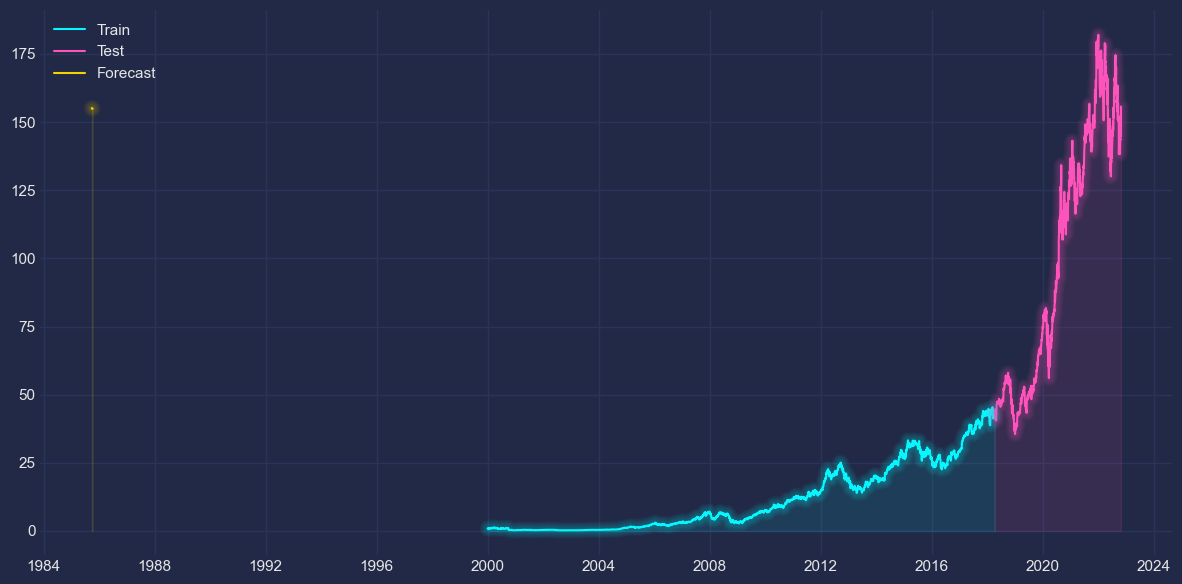

In [322]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_values.index, forecast_values, label='Forecast')
plt.legend()
plt.tight_layout()
save_plots('Forecast')
mplcyberpunk.add_glow_effects()
plt.show()

## Perform an augmented Dickey Fuller test (ADF) to check for the stationarity of Apple stock.

In [291]:
y=aapl_stock['Close']
# Perform Augmented Dickey-Fuller test
results=adfuller(y)

In [292]:
# Extract and print test statistics
adf_statistic = results[0]
p_value = results[1]
critical_values = results[4]

In [293]:
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: 1.7607826162406663
p-value: 0.9982679800886297
Critical Values:
   1%: -3.431495751697216
   5%: -2.862046312212644
   10%: -2.5670395082213586


In [294]:
# Check the p-value to determine stationarity
if p_value <= 0.05:
    print("Reject the null hypothesis. The data is stationary.")
else:
    print("Fail to reject the null hypothesis. The data is non-stationary.")

Fail to reject the null hypothesis. The data is non-stationary.


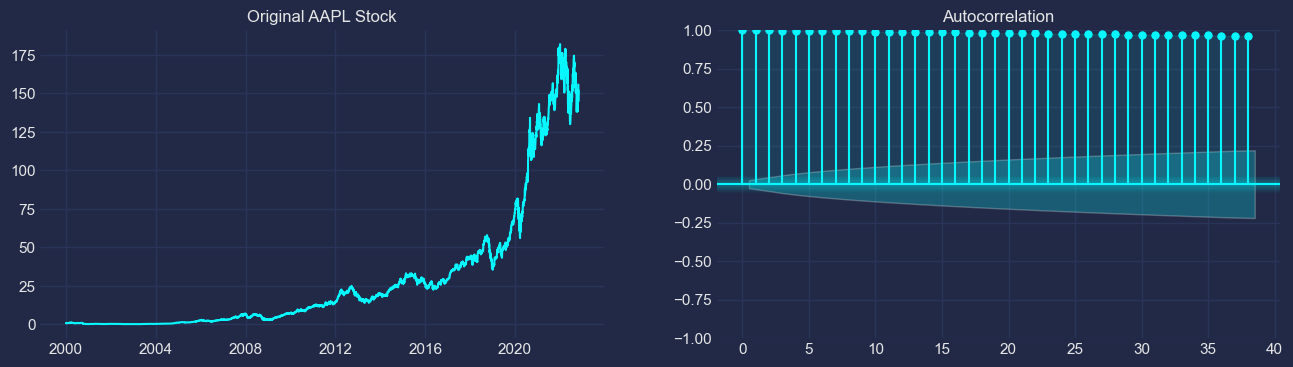

In [323]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(y)
ax1.set_title('Original AAPL Stock')
plot_acf(y,ax=ax2)
mplcyberpunk.add_glow_effects()
save_plots('Original AAPL Stock')
plt.show()

- This suggests that the data is non-stationary

In [296]:
# Check the number of difference to be taken
ndiffs(y,test='adf')

1

- We should take only 1 difference

In [297]:
# Compute the first difference
y_diff = y.diff().dropna()

# Perform ADF test on differenced series
result_diff = adfuller(y_diff)

adf_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]
critical_values_diff = result_diff[4]

In [298]:
print(f'ADF Statistic: {adf_statistic_diff}')
print(f'p-value: {p_value_diff}')
print('Critical Values:')
for key, value in critical_values_diff.items():
    print(f'   {key}: {value}')

ADF Statistic: -13.468452808081905
p-value: 3.4195868446357764e-25
Critical Values:
   1%: -3.431495751697216
   5%: -2.862046312212644
   10%: -2.5670395082213586


In [299]:
# Check the p-value to determine stationarity
if p_value_diff <= 0.05:
    print("Reject the null hypothesis. The data is stationary.")
else:
    print("Fail to reject the null hypothesis. The data is non-stationary.")

Reject the null hypothesis. The data is stationary.


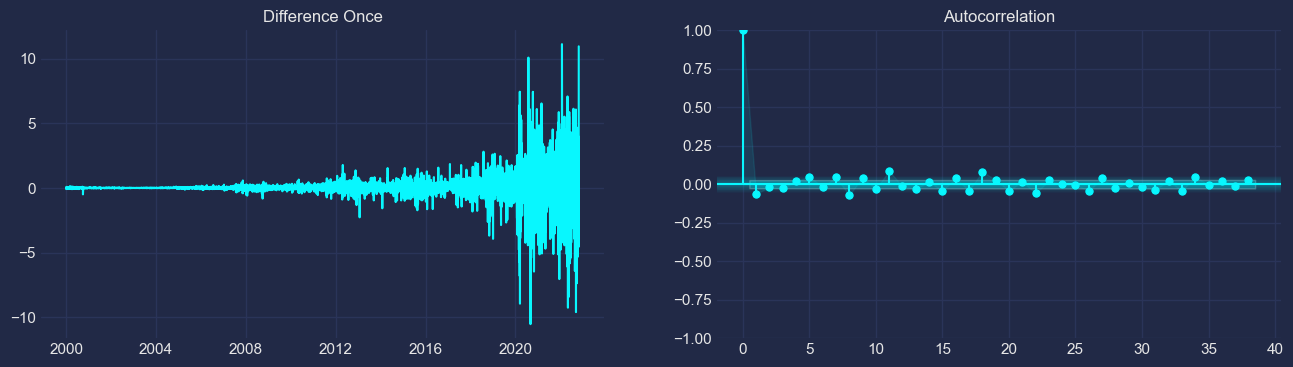

In [324]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_diff)
ax1.set_title('Difference Once')
plot_acf(y_diff,ax=ax2)
save_plots('Difference Once')
mplcyberpunk.add_glow_effects()
plt.show()

## Analyze the ACF and PACF plots for Apple's historical stock prices, strategize for ARIMA modeling, determine the appropriate values of p, d, and q, and forecast the month end share price value for the next 12 months

C:\Users\rajal\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



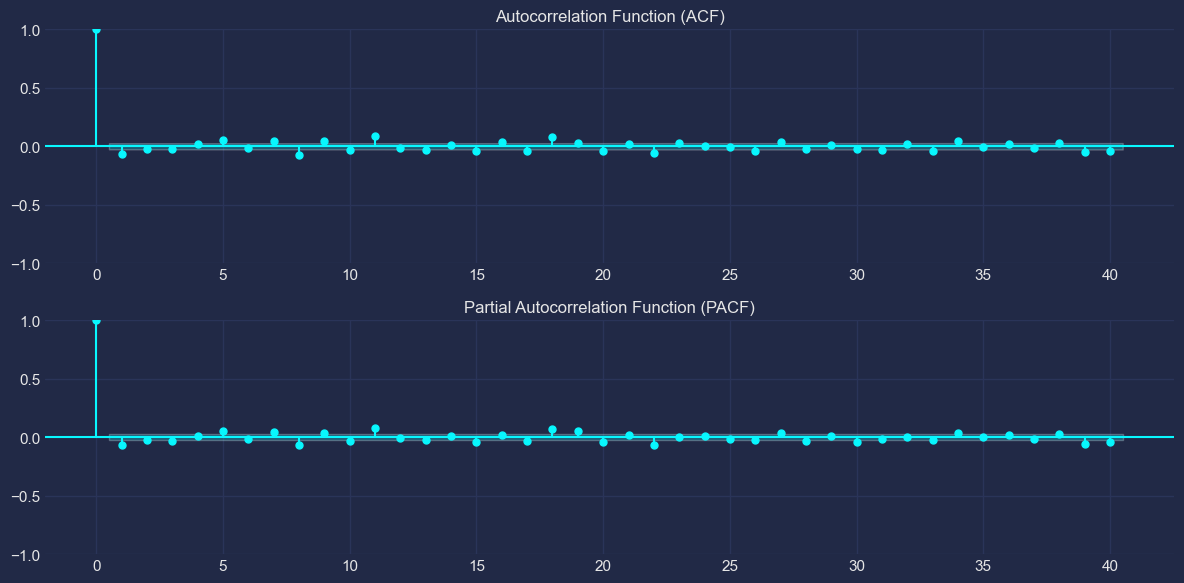

In [325]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(y_diff.dropna(), lags=40, ax=plt.gca(), title='Autocorrelation Function (ACF)')
save_plots('ACF')
plt.subplot(2, 1, 2)
plot_pacf(y_diff.dropna(), lags=40, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
save_plots('PACF')
plt.tight_layout()
plt.show()

C:\Users\rajal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\rajal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\rajal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



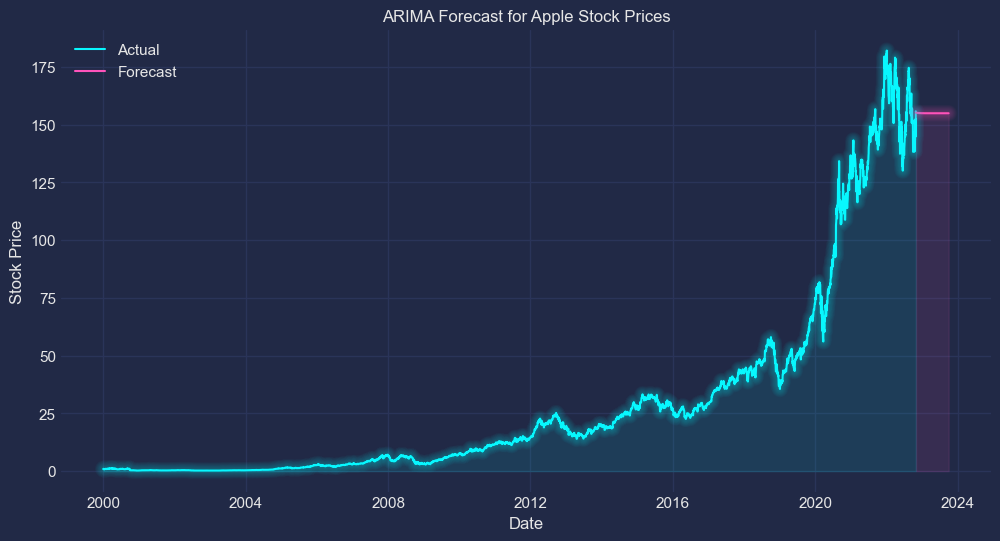

In [326]:
# Fit ARIMA model
p = 1 # Replace with your chosen value
d = 1  # Since your data is stationary
q = 1  # Replace with your chosen value

model = SARIMAX(y, order=(p, d, q))
results = model.fit()

# Forecast next 12 months
forecast_values = results.get_forecast(steps=12)

# Create the index for the forecast values
forecast_index = pd.date_range(start=y.index[-1], periods=12, freq='M')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Actual')
plt.plot(forecast_index, forecast_values.predicted_mean, label='Forecast')
plt.title('ARIMA Forecast for Apple Stock Prices')
save_plots('ARIMA Forecast for Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
mplcyberpunk.add_glow_effects()
plt.show()

In [303]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5745
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -8257.196
Date:                Mon, 29 Jan 2024   AIC                          16520.391
Time:                        20:08:41   BIC                          16540.359
Sample:                             0   HQIC                         16527.341
                               - 5745                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2882      0.058      4.994      0.000       0.175       0.401
ma.L1         -0.3540      0.057     -6.237      0.000      -0.465      -0.243
sigma2         1.0378      0.005    195.245      0.0

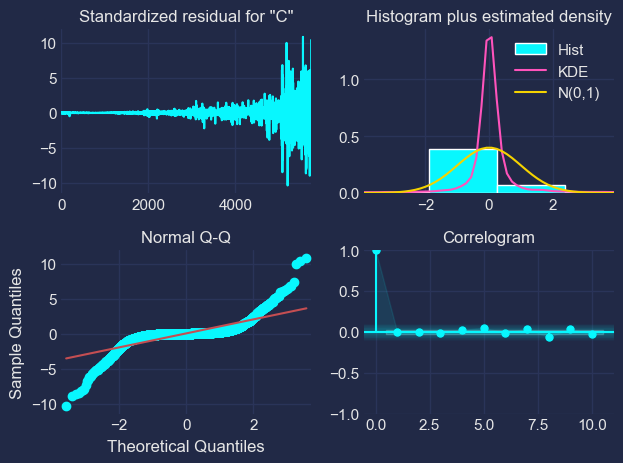

In [327]:
results.plot_diagnostics()
mplcyberpunk.add_glow_effects()
save_plots('ARIMA Diagnostics')
plt.tight_layout()

## Find the mean absolute percentage error (MAPE) for a 12 month period to validate the model

In [305]:
actual_values = y[-12:]
forecast_values = results.get_forecast(steps=12)
forecast_values=forecast_values.predicted_mean

C:\Users\rajal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [306]:
# Calculate MAPE
mape = np.mean(np.abs((actual_values.values - forecast_values) / actual_values.values)) * 100

print(f'MAPE: {mape:.2f}%')

MAPE: 6.20%


## Identify the top 2 companies from each sector based on market capitalization, create trend charts for the month end share price for the last five years (using the variable "adjusted close"), display the 12 month rolling mean and standard deviation in the same chart, and share your observations regarding the stationarity of all companies

In [307]:
sectors=master_df['sector'].unique()

In [308]:
# Selecting the top 2 sector for each sector
sector_to_2_company={}
for sector in sectors:
    sector_to_2_company[sector]=list(master_df[master_df['sector']==sector].sort_values('Market Cap',ascending=False)['Symbol'].head(2).values)

In [309]:
sector_to_2_company

{'Information Technology': ['AAPL', 'MSFT'],
 'Consumer Discretionary': ['AMZN', 'TSLA'],
 'Utilities': ['AEP', 'EXC'],
 'Health Care': ['AZN', 'AMGN'],
 'Communication Services': ['GOOG', 'GOOGL'],
 'Consumer Staples': ['PEP', 'COST'],
 'Industrials': ['HON', 'CSX']}

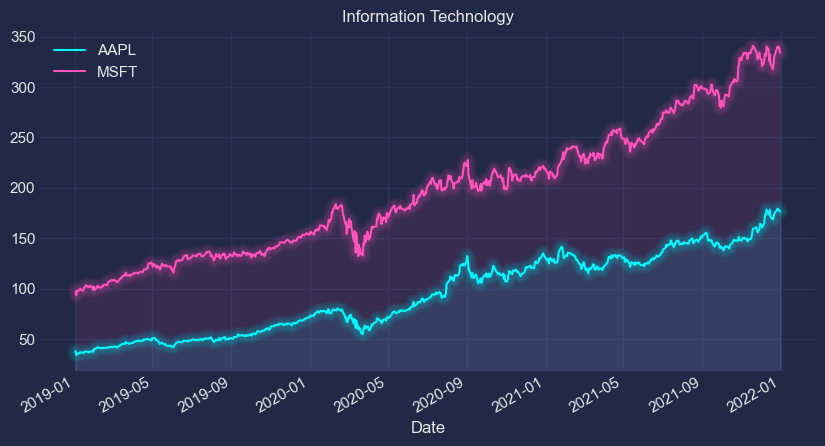

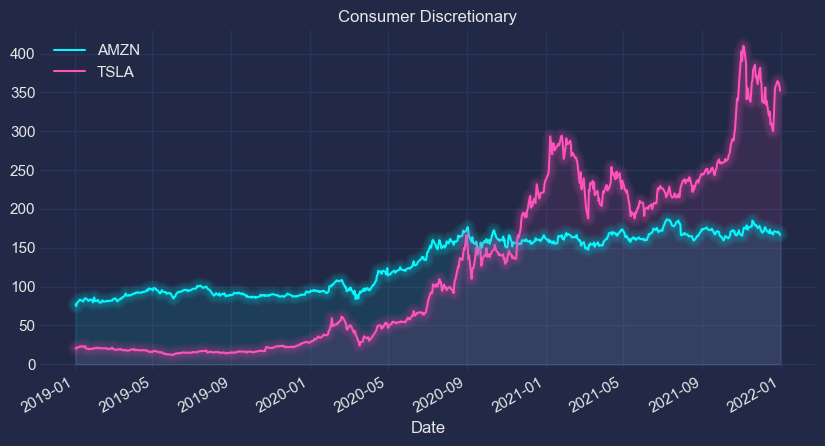

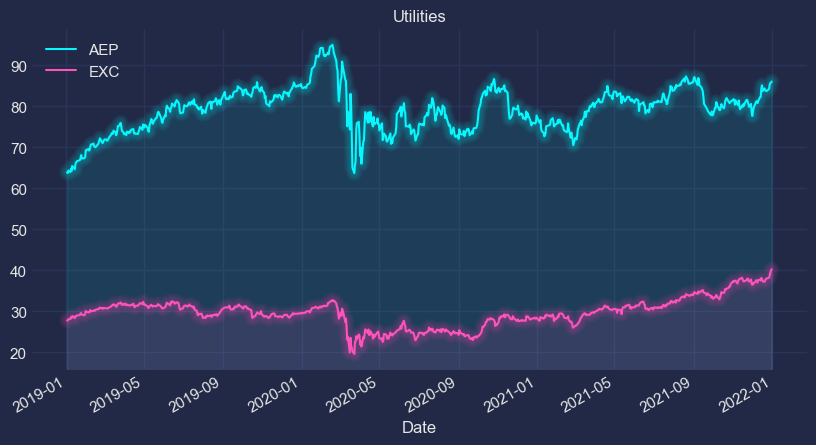

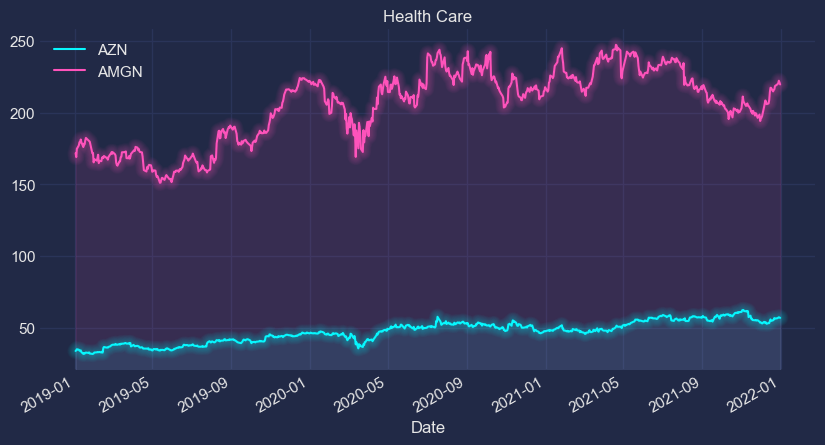

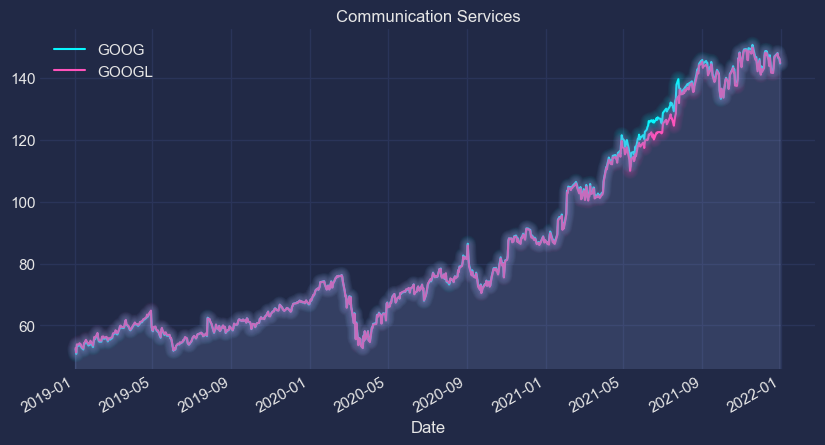

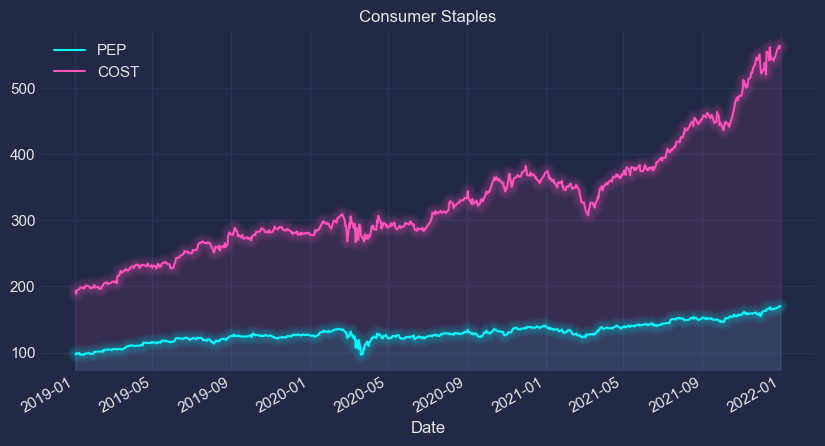

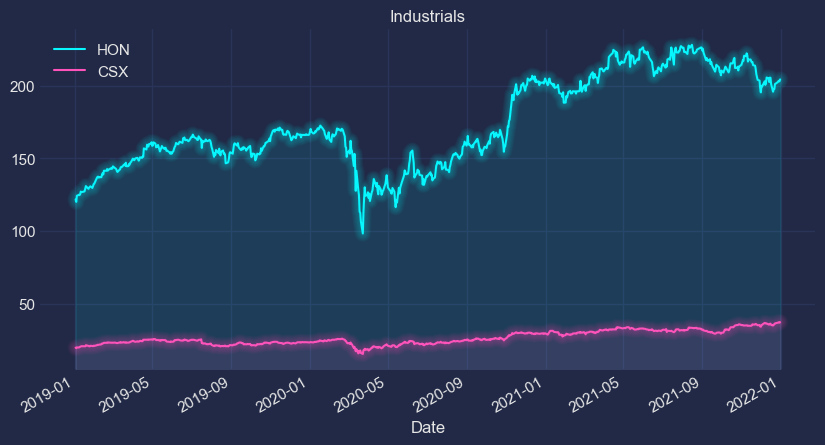

In [310]:
plt.style.use('cyberpunk')
for sector in sector_to_2_company.keys():
    plt.figure(figsize=(10,5))
    for indx,company in enumerate(sector_to_2_company[sector]):
        df=all_stock_data[company]
        last_year_upper=df['Date'].dt.year.tail(1).values
        last_year_lower=df['Date'].dt.year.tail(1).values-4
        df[(df['Date'].dt.year > last_year_lower[0]) & (df['Date'].dt.year < last_year_upper[0])].set_index('Date')['Adj Close'].plot()
        plt.title(sector)
        save_plots(f'Sector stock {sector}')
    plt.legend(sector_to_2_company[sector])
    mplcyberpunk.add_glow_effects()
    plt.show()

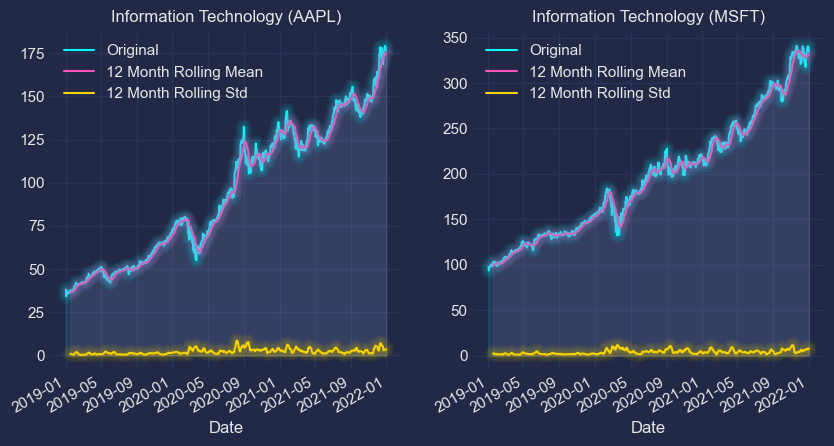

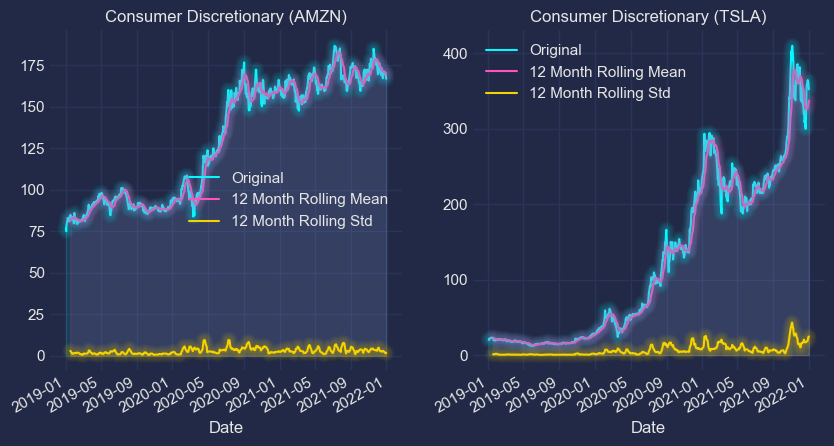

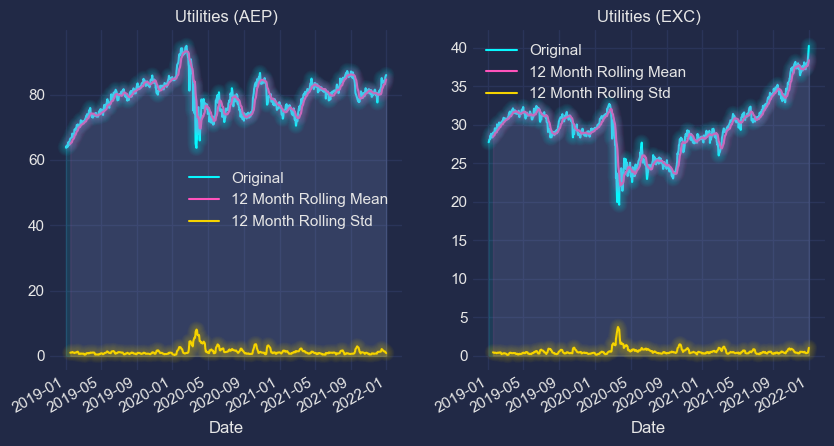

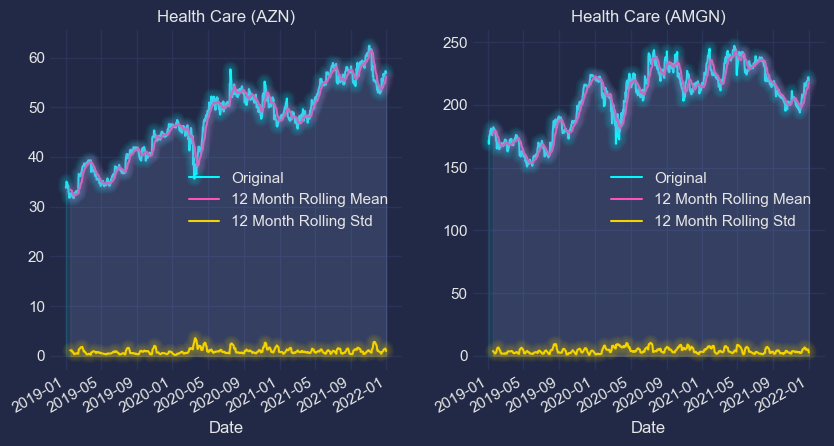

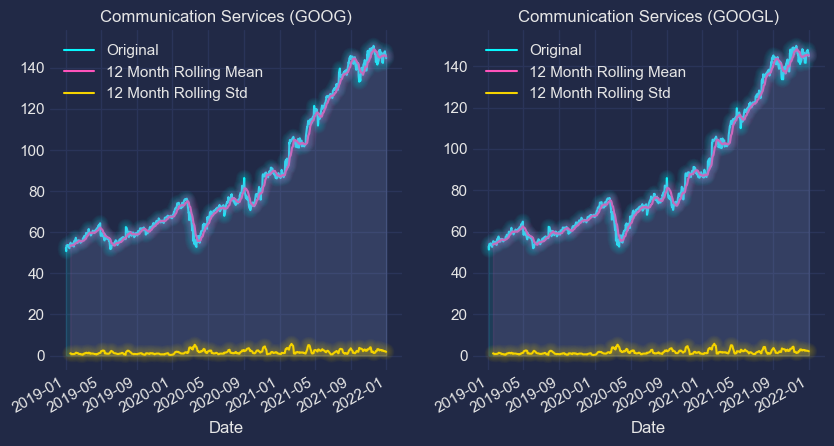

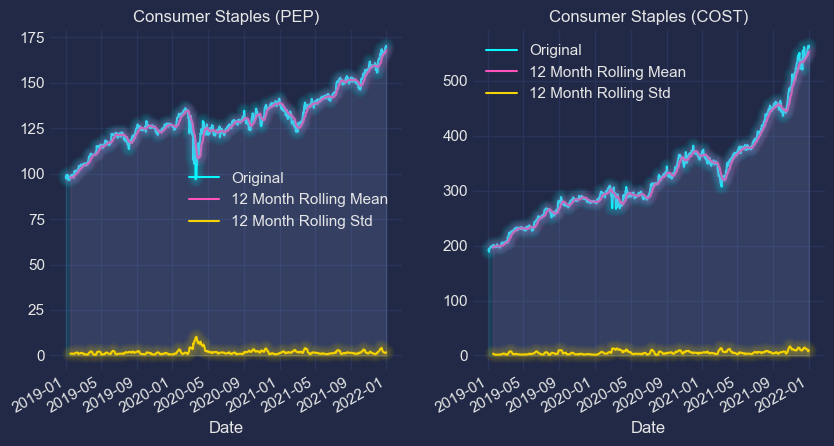

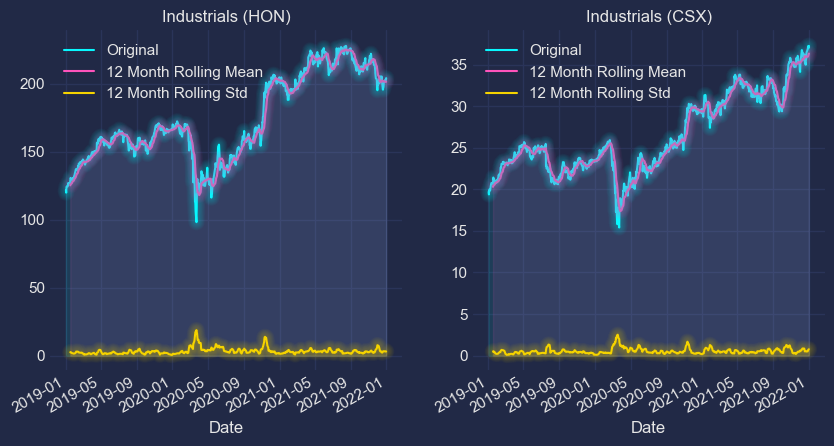

In [328]:
plt.style.use('cyberpunk')
for sector in sector_to_2_company.keys():
    plt.figure(figsize=(10,5))
    for indx,company in enumerate(sector_to_2_company[sector]):
        plt.subplot(1,2,indx+1)
        df=all_stock_data[company]
        last_year_upper=df['Date'].dt.year.tail(1).values
        last_year_lower=df['Date'].dt.year.tail(1).values-4
        df[(df['Date'].dt.year > last_year_lower[0]) & (df['Date'].dt.year < last_year_upper[0])].set_index('Date')['Adj Close'].plot()
        df[(df['Date'].dt.year > last_year_lower[0]) & (df['Date'].dt.year < last_year_upper[0])].set_index('Date')['Adj Close'].rolling(window=12).mean().plot()
        df[(df['Date'].dt.year > last_year_lower[0]) & (df['Date'].dt.year < last_year_upper[0])].set_index('Date')['Adj Close'].rolling(window=12).std().plot()
        plt.title(f'{sector} ({company})')
        save_plots(f'{sector} ({company})')
        plt.legend(['Original','12 Month Rolling Mean','12 Month Rolling Std'])
        mplcyberpunk.add_glow_effects()
    plt.show()

- Findings
    - The rolling mean exhibits a clear resemblance to the trends observed in the original time series plot, capturing the underlying pattern and trend of the data.
    - The consistent alignment between the rolling mean and the trends in the time series plot indicates a steady, discernible pattern in the data
    
    - Companies:
        - Amazon
        - Tesls Inc.
        - Exelon
        - Amgen
        - PepsiCo
        - Honeywell,
        - CSX Corporation
    - The above companies rolling mean diverges from the trends. It indicate a disparity in capturing the underlying pattern or trend.
        
    - The below company rolling standard deviation remains relatively flat, implying that the volatility or variability in the data is stable over the observed period.
        - Apple Inc.
        - Microsoft
        - Alphabet Inc. (Class C)
        - Alphabet Inc. (Class A)
        - Costco
    - The stability in volatility suggests a consistent spread of data points around the trend, with no significant changes in the amplitude of fluctuations.
    
**Over all the above stocks are not stationary**

## Conduct an ADF test to verify the stationarity of the companies selected in the previous step

In [116]:
for stock_symbol in np.array(list(sector_to_2_company.values())).flatten():
    y=all_stock_data[stock_symbol]['Close']
    # Perform Augmented Dickey-Fuller test
    results=adfuller(y)

    # Extract and print test statistics
    p_value = results[1]

    # Check the p-value to determine stationarity
    if p_value <= 0.05:
        print(f'{stock_symbol}: Reject the null hypothesis. The data is stationary.')
    else:
        print(f'{stock_symbol}: Fail to reject the null hypothesis. The data is non-stationary.')

AAPL: Fail to reject the null hypothesis. The data is non-stationary.
MSFT: Fail to reject the null hypothesis. The data is non-stationary.
AMZN: Fail to reject the null hypothesis. The data is non-stationary.
TSLA: Fail to reject the null hypothesis. The data is non-stationary.
AEP: Fail to reject the null hypothesis. The data is non-stationary.
EXC: Fail to reject the null hypothesis. The data is non-stationary.
AZN: Fail to reject the null hypothesis. The data is non-stationary.
AMGN: Fail to reject the null hypothesis. The data is non-stationary.
GOOG: Fail to reject the null hypothesis. The data is non-stationary.
GOOGL: Fail to reject the null hypothesis. The data is non-stationary.
PEP: Fail to reject the null hypothesis. The data is non-stationary.
COST: Fail to reject the null hypothesis. The data is non-stationary.
HON: Fail to reject the null hypothesis. The data is non-stationary.
CSX: Fail to reject the null hypothesis. The data is non-stationary.


- Findings
    - From the ADF test result we know that the selected stock are not stationary

## Perform batch forecasting for the top 2 companies from each sector based on market capitalization for the weekend share price value for the next 12 months using Auto ARIMA,and find the MAPE for a 12 month period to validate the model

In [138]:
forecast_result={}
for sector in sector_to_2_company:
    for stock in sector_to_2_company[sector]:
        stock_df=all_stock_data[stock]['Close']
        
        model=auto_arima(stock_df,seasonal=True,m=12)
        
        forecast_values, conf_int = model.predict(n_periods=12, return_conf_int=True)
        
        forecast_result[stock]={
            'Sector':sector,
            'Forecast':forecast_values
        }
        
         # Calculate MAPE for a 12-month period
        actual_values = stock_df[-12:]
        mape = np.mean(np.abs((actual_values.values - forecast_values) / actual_values.values)) * 100
        print(f'MAPE for {stock} in {sector} sector: {mape:.2f}%')

MAPE for AAPL in Information Technology sector: 6.41%
MAPE for MSFT in Information Technology sector: 2.16%
MAPE for AMZN in Consumer Discretionary sector: 9.11%
MAPE for TSLA in Consumer Discretionary sector: 3.90%
MAPE for AEP in Utilities sector: 3.73%
MAPE for EXC in Utilities sector: 3.97%
MAPE for AZN in Health Care sector: 5.52%
MAPE for AMGN in Health Care sector: 6.10%
MAPE for GOOG in Communication Services sector: 3.69%
MAPE for GOOGL in Communication Services sector: 3.36%
MAPE for PEP in Consumer Staples sector: 3.69%
MAPE for COST in Consumer Staples sector: 6.61%
MAPE for HON in Industrials sector: 11.13%
MAPE for CSX in Industrials sector: 3.61%


# Excel

In [117]:
with pd.ExcelWriter(CSV_PATH+'OnlineRetail.xlsx',engine='xlsxwriter', mode='w') as writer:
    for symbol in np.array(list(sector_to_2_company.values())).flatten():
        all_stock_data[symbol].to_excel(writer,sheet_name=symbol,index=False)

# SQL

In [118]:
master_df['Last Sale']=[float(str(x[1:]).replace(',','')) for x in master_df['Last Sale']]

In [119]:
master_df.to_csv('metrics_ratio.csv')

In [120]:
market_cap.to_csv('market_cap.csv')

# Tableau

<a href='https://public.tableau.com/app/profile/raja.lairenmayum/viz/ShareMarketAnalysis_17062596099260/CompanyTrendsDashboard?publish=yes'>Please check the viz</a>

In [121]:
selected_stock={}
stock_data=all_stock_data.copy()
for sector in sector_to_2_company.keys():
    for company in np.array(list(sector_to_2_company[sector])).ravel():
        stock_data[company]['Adj_Close_Rolling_Mean']=stock_data[company]['Adj Close'].rolling(window=12).mean()
        stock_data[company]['Adj_Close_Rolling_Std']=stock_data[company]['Adj Close'].rolling(window=12).std()
        selected_stock[company]=stock_data[company]

## Exporting the data as Excel file

In [122]:
with pd.ExcelWriter(TABLEAU_PATH+'Top2StockSector.xlsx',engine='xlsxwriter', mode='w') as writer:
    for stock in selected_stock.keys():
         selected_stock[stock].to_excel(writer,sheet_name=stock,index=False)

In [123]:
pd.concat((master_df[['Symbol','company','sector','subsector']],cluster1_df),axis=1).to_excel(TABLEAU_PATH+'Cluster_data.xlsx',index=False)

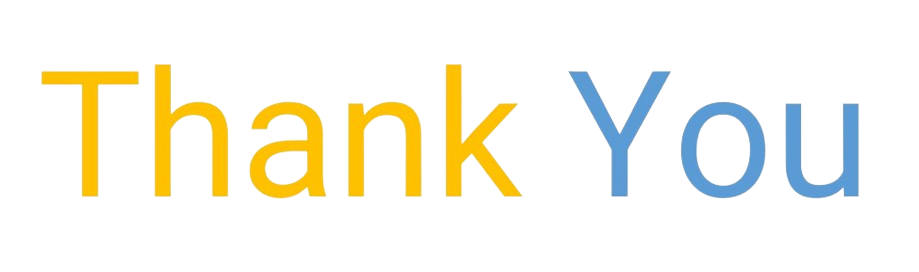